# =============================================
## GHI CHÚ TỔNG QUAN (NOTE – DÀNH CHO KAGGLE)
# =============================================
 **Mục tiêu**
 - Fine-tune mô hình T5 (seq2seq) cho bài toán Text-to-SQL trên Kaggle.
 - Dùng dataset công khai (b-mc2/sql-create-context, Clinton/Text-to-sql-v1, knowrohit07/know_sql),
 sau đó trộn, tiền xử lý (tokenize), huấn luyện, lưu mô hình.
 - Không thay đổi logic cốt lõi; chỉ bổ sung chú thích chi tiết.

 **Luồng chính**
 1) Cài đặt thư viện → Import.
 2) Nạp/ghép dataset có sẵn → lưu cache (merged_dataset).
 3) Tiền xử lý (tokenize) → lưu cache (tokenized_datasets).
 4) Kiểm thử zero-shot (baseline) trên model gốc.
 5) Huấn luyện full fine-tune → lưu mô hình đã fine-tune.
 6) Kiểm thử lại với mô hình fine-tuned + đánh giá (ROUGE) mẫu nhỏ.
 7) Đóng gói mô hình (zip) để tải xuống / dùng về sau.

 **Đầu ra (sản phẩm)**
 - Thư mục model đã fine-tune: /kaggle/working/sql_t5_finetuned
 - Có thể nạp về app (FastAPI/Flask/.NET-bridge) bằng from_pretrained("/kaggle/working/sql_t5_finetuned").

# =============================================
## GHI CHÚ TỔNG QUAN (NOTE – DÀNH CHO KAGGLE)
# =============================================
 **Mục tiêu**
 - Fine-tune mô hình T5 (seq2seq) cho bài toán Text-to-SQL trên Kaggle.
 - Dùng dataset công khai (b-mc2/sql-create-context, Clinton/Text-to-sql-v1, knowrohit07/know_sql),
 sau đó trộn, tiền xử lý (tokenize), huấn luyện, lưu mô hình.
 - Không thay đổi logic cốt lõi; chỉ bổ sung chú thích chi tiết.

 **Luồng chính**
 1) Cài đặt thư viện → Import.
 2) Nạp/ghép dataset có sẵn → lưu cache (merged_dataset).
 3) Tiền xử lý (tokenize) → lưu cache (tokenized_datasets).
 4) Kiểm thử zero-shot (baseline) trên model gốc.
 5) Huấn luyện full fine-tune → lưu mô hình đã fine-tune.
 6) Kiểm thử lại với mô hình fine-tuned + đánh giá (ROUGE) mẫu nhỏ.
 7) Đóng gói mô hình (zip) để tải xuống / dùng về sau.

 **Đầu ra (sản phẩm)**
 - Thư mục model đã fine-tune: /kaggle/working/sql_t5_finetuned
 - Có thể nạp về app (FastAPI/Flask/.NET-bridge) bằng from_pretrained("/kaggle/working/sql_t5_finetuned").

In [ ]:
# Cài đặt thư viện datasets nếu chưa có
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 38.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 19.0.1
    Uninstalling pyarrow-19.0.1:
      Successfully uninstalled pyarrow-19.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
bigframes 2.12.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.1.

In [ ]:
# Cài đặt thư viện evaluate
!pip install evaluate 


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00


# ==============================
# 2) IMPORT CÁC THƯ VIỆN CẦN THIẾT
# ==============================

In [ ]:
import torch; 
print(torch.__version__, torch.cuda.is_available())

2.6.0+cu124 True


In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, load_dataset, interleave_datasets, load_from_disk # Dataset Huggingface
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer # Model và Tokenizer cho trainning
import torch # Thư viện PyTorch tăng tốc độ xử lý GPU, tensor
import time # Ghi thời gian trainning
import evaluate # Thư viện evaluate để đánh giá mô hình (BLEU, ROUGE)
import pandas as pd # Thư viện pandas để xử lý dữ liệu dạng bảng/kết quả
import numpy as np # Thư viện numpy để xử lý mảng


import warnings
warnings.filterwarnings("ignore") # Bỏ qua các cảnh báo không cần thiết

2025-10-31 18:04:14.634643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761933854.815323      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761933854.871881      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Import thư viện transformers và huggingface_hub
!pip install transformers huggingface_hub 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 14.1 MB/s eta 0:00:0000:01
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 1.0.0rc2
    Uninstalling huggingface-hub-1.0.0rc2:
      Successfully uninstalled huggingface-hub-1.0.0rc2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.38.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.0a1 which is incompatible.


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration # Model và Tokenizer T5

import os # Thư viện os để thao tác với hệ thống tệp

# ==============================
# 3) CẤU HÌNH ĐƯỜNG DẪN VÀ THIẾT BỊ
# ==============================

In [ ]:
drive_model_path = '/kaggle/working/' # Đường dẫn lưu model trên Kaggle

In [ ]:
torch.cuda.is_available() # Kiểm tra GPU có sẵn không, trả về True hoặc False

True

In [ ]:
from huggingface_hub import snapshot_download

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1) Tải snapshot repo model về LOCAL FOLDER (chỉ gọi API 1 lần, không đụng 'additional_chat_templates')
#   - repo_id 't5-small' sẽ redirect về 'google-t5/t5-small'
local_dir = snapshot_download(repo_id="t5-small") 

Fetching 20 files:   0%|          | 0/20 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/537 [00:00<?, ?B/s]

onnx/decoder_model_merged.onnx:   0%|          | 0.00/233M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.47k [00:00<?, ?B/s]

onnx/decoder_model.onnx:   0%|          | 0.00/232M [00:00<?, ?B/s]

flax_model.msgpack:   0%|          | 0.00/242M [00:00<?, ?B/s]

onnx/decoder_model_quantized.onnx:   0%|          | 0.00/58.4M [00:00<?, ?B/s]

onnx/decoder_with_past_model.onnx:   0%|          | 0.00/220M [00:00<?, ?B/s]

onnx/decoder_with_past_model_quantized.o(…):   0%|          | 0.00/55.2M [00:00<?, ?B/s]

onnx/decoder_model_merged_quantized.onnx:   0%|          | 0.00/58.7M [00:00<?, ?B/s]

onnx/encoder_model.onnx:   0%|          | 0.00/141M [00:00<?, ?B/s]

onnx/encoder_model_quantized.onnx:   0%|          | 0.00/35.5M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

rust_model.ot:   0%|          | 0.00/242M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/242M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

In [ ]:
model_name='t5-small' # Tên model nền; code gốc chọn t5-small cho baseline/finetune

# tokenizer = T5Tokenizer.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(local_dir, local_files_only=True)

# Trên Kaggle GPU có thể dùng bfloat16, còn local CPU thì để mặc định FP32
if device == "cuda":
    original_model = T5ForConditionalGeneration.from_pretrained(
        model_name, torch_dtype=torch.bfloat16
    ).to(device)
else:
    original_model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

import warnings
warnings.filterwarnings("ignore", message="You are using the default legacy behaviour")


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


# ==============================
# 4 ) NẠP/CHUẨN BỊ DATASET (CÓ CACHE)
# ==============================

# ==== Load OLSM from RAW JSON/JSONL và clean data ====

In [ ]:
# ==== ONE-CELL: Load OLSM from RAW JSON/JSONL (tự sửa & split) ====
from datasets import load_dataset
import json, re, os, codecs

RAW_FILES = [
    "/kaggle/input/olsm-data/dataset-olsm.json",
    "/kaggle/input/olsm-data/dataset-olsm2.json",
]
OUT = "/kaggle/working/olsm-clean.jsonl"
os.makedirs(os.path.dirname(OUT), exist_ok=True)

# thay “smart quotes” -> ASCII
SMART = str.maketrans({
    "“": '"', "”": '"', "„": '"', "«": '"', "»": '"',
    "‘": "'", "’": "'", "‚": "'", "‹": "'", "›": "'",
})

def _fix_inner_quotes(text: str, field: str) -> str:
    # Đổi dấu " bên trong giá trị field -> ' và escape \n,\t
    pat = re.compile(rf'"{field}"\s*:\s*"(.*?)"', re.DOTALL)
    def repl(m):
        v = m.group(1)
        v = v.replace('\\"', '"')        # bỏ escape cũ lộn xộn
        v = v.replace('"', "'")          # " -> '
        v = v.replace("\r\n","\n").replace("\r","\n")
        v = v.replace("\n","\\n").replace("\t","\\t")
        return f'"{field}":"{v}"'
    return pat.sub(repl, text)

def _objects_from_text(txt: str):
    # nếu là JSON array chuẩn -> parse một lần
    t = txt.strip()
    if t.startswith("[") and t.endswith("]"):
        try:
            arr = json.loads(t)
            for obj in arr:
                yield obj
            return
        except Exception:
            pass
    # còn lại coi như JSONL "lẫn lộn": tách các object dính liền }{
    txt = re.sub(r"}\s*{", "}\n{", txt)
    for line in txt.splitlines():
        L = line.strip().rstrip(",")
        if not L:
            continue
        try:
            yield json.loads(L)
        except Exception:
            # cố gắng trích đoạn {...} lớn nhất rồi sửa
            s_idx, e_idx = L.find("{"), L.rfind("}")
            if s_idx == -1 or e_idx == -1 or e_idx <= s_idx:
                continue
            seg = L[s_idx:e_idx+1]
            for f in ("question","context","answer"):
                seg = _fix_inner_quotes(seg, f)
            seg = re.sub(r",\s*}", "}", seg)
            try:
                yield json.loads(seg)
            except Exception:
                continue

# Gộp & làm sạch hai file vào một JSONL
kept = 0
with open(OUT, "w", encoding="utf-8") as w:
    for path in RAW_FILES:
        with open(path, "rb") as f:
            txt = f.read().decode("utf-8", errors="ignore")
        # bỏ BOM + smart quotes
        bom = codecs.BOM_UTF8.decode("utf-8")
        if txt.startswith(bom): txt = txt.lstrip(bom)
        txt = txt.translate(SMART)

        for obj in _objects_from_text(txt):
            if not all(k in obj for k in ("question","context","answer")):
                continue
            q = str(obj["question"]).strip()
            c = str(obj["context"]).strip()
            a = str(obj["answer"]).strip()
            if not (q and c and a):
                continue
            w.write(json.dumps({"question": q, "context": c, "answer": a}, ensure_ascii=False) + "\n")
            kept += 1

print(f"[OLSM] Wrote {kept} cleaned examples -> {OUT}")

# Load 1 lần từ file sạch và split 80/10/10
olsm_full  = load_dataset("json", data_files=OUT, split="train")
tmp        = olsm_full.train_test_split(test_size=0.2, seed=42)
olsm_train = tmp["train"]
tmp2       = tmp["test"].train_test_split(test_size=0.5, seed=42)
olsm_test, olsm_val = tmp2["train"], tmp2["test"]

olsm_train, olsm_test, olsm_val  # để bạn thấy kích thước ba split


[OLSM] Wrote 10771 cleaned examples -> /kaggle/working/olsm-clean.jsonl


Generating train split: 0 examples [00:00, ? examples/s]

(Dataset({
     features: ['question', 'context', 'answer'],
     num_rows: 8616
 }),
 Dataset({
     features: ['question', 'context', 'answer'],
     num_rows: 1077
 }),
 Dataset({
     features: ['question', 'context', 'answer'],
     num_rows: 1078
 }))

In [ ]:
import shutil

src = "/kaggle/working/olsm-clean.jsonl"
dst = "/kaggle/working/olsm-clean.zip"

# nén file JSONL thành zip
shutil.make_archive(dst.replace(".zip", ""), 'zip', root_dir="/kaggle/working", base_dir="olsm-clean.jsonl")
print("✅ Created zip:", dst)


✅ Created zip: /kaggle/working/olsm-clean.zip


# **XÓA CACHE CŨ**

In [ ]:
import shutil, os

# Thư mục cache cũ
CACHE_DIR = "merged_dataset"

if os.path.exists(CACHE_DIR):
    shutil.rmtree(CACHE_DIR)
    print(f"🗑️ Deleted old cache folder: {CACHE_DIR}")
else:
    print("✅ No old merged_dataset found, will rebuild from scratch")


✅ No old merged_dataset found, will rebuild from scratch


In [ ]:
from datasets import load_dataset, load_from_disk, DatasetDict, interleave_datasets, concatenate_datasets

# Cố gắng nạp dataset đã merge sẵn từ cache "merged_dataset" để tiết kiệm thời gian
try:
    dataset = load_from_disk("merged_dataset")
    print("Loaded Merged Dataset")
except:
    # Nếu không có cache, tiến hành tải và merge các dataset và chia split thủ công

    # =========================
    # 4.0) Local OLSM datasets
    # =========================

    olsm_full = load_dataset("json", data_files="/kaggle/working/olsm-clean.jsonl", split="train")
    _tmp = olsm_full.train_test_split(test_size=0.2, seed=42)
    olsm_train = _tmp["train"]
    _tmp2 = _tmp["test"].train_test_split(test_size=0.5, seed=42)
    olsm_test, olsm_val = _tmp2["train"], _tmp2["test"]
    print("OLSM splits:", olsm_train.num_rows, olsm_val.num_rows, olsm_test.num_rows)
    
        

    # =========================
    # 4.1) b-mc2/sql-create-context
    # =========================
    dataset_scc_train = load_dataset("b-mc2/sql-create-context", split='train[:80%]')       # 80% train
    dataset_scc_test  = load_dataset("b-mc2/sql-create-context", split='train[-20%:-10%]')  # 10% test
    dataset_scc_val   = load_dataset("b-mc2/sql-create-context", split='train[-10%:]')      # 10% val

    # =========================
    # 4.2) Clinton/Text-to-sql-v1 (đổi tên cột)
    # =========================
    dataset_tts_train = load_dataset("Clinton/Text-to-sql-v1", split='train[:80%]')
    dataset_tts_train = dataset_tts_train.remove_columns(['source', 'text'])
    dataset_tts_train = dataset_tts_train.rename_columns({'instruction':'question','input':'context','response':'answer'})

    dataset_tts_test  = load_dataset("Clinton/Text-to-sql-v1", split='train[-20%:-10%]')
    dataset_tts_test  = dataset_tts_test.remove_columns(['source', 'text'])
    dataset_tts_test  = dataset_tts_test.rename_columns({'instruction':'question','input':'context','response':'answer'})

    dataset_tts_val   = load_dataset("Clinton/Text-to-sql-v1", split='train[-10%:]')
    dataset_tts_val   = dataset_tts_val.remove_columns(['source', 'text'])
    dataset_tts_val   = dataset_tts_val.rename_columns({'instruction':'question','input':'context','response':'answer'})

    # =========================
    # 4.3) knowrohit07/know_sql
    # =========================
    dataset_ks_train  = load_dataset("knowrohit07/know_sql", split='validation[:80%]')
    dataset_ks_test   = load_dataset("knowrohit07/know_sql", split='validation[-20%:-10%]')
    dataset_ks_val    = load_dataset("knowrohit07/know_sql", split='validation[-10%:]')


    # 4.4) Ghép 3 nguồn lại bằng interleave_datasets để tăng đa dạng dữ liệu
    # =========================
    from datasets import interleave_datasets, concatenate_datasets, DatasetDict

    # 4.4.1) Interleave 3 bộ HF (mặc định first_exhausted -> dừng ở bộ ngắn nhất để giữ cân bằng)
    mix_train = interleave_datasets([dataset_scc_train, dataset_tts_train, dataset_ks_train])
    mix_test  = interleave_datasets([dataset_scc_test,  dataset_tts_test,  dataset_ks_test])
    mix_val   = interleave_datasets([dataset_scc_val,   dataset_tts_val,   dataset_ks_val])

    # 4.4.2) Gắn nhãn nguồn để thống kê
    def tag(ds, name):
        return ds.map(lambda ex: {"_src": name})

    mix_train, mix_test, mix_val = tag(mix_train, "HF"), tag(mix_test, "HF"), tag(mix_val, "HF")
    olsm_train_t, olsm_test_t, olsm_val_t = tag(olsm_train, "OLSM"), tag(olsm_test, "OLSM"), tag(olsm_val, "OLSM")

    # 4.4.3) Concat với OLSM ĐỨNG TRƯỚC để khi dedup thì OLSM được giữ lại nếu trùng
    dataset = DatasetDict({
        "train":      concatenate_datasets([olsm_train_t, mix_train]).shuffle(seed=42),
        "test":       concatenate_datasets([olsm_test_t,  mix_test]).shuffle(seed=42),
        "validation": concatenate_datasets([olsm_val_t,   mix_val]).shuffle(seed=42),
    })


    # ==== Deduplicate by (question||context||answer) ====
    import hashlib
    from datasets import DatasetDict

    def add_hash(ex):
        s = ex["question"] + "||" + ex["context"] + "||" + ex["answer"]
        ex["_h"] = hashlib.sha1(s.encode("utf-8")).hexdigest()
        return ex

    dataset = DatasetDict({ k: v.map(add_hash) for k, v in dataset.items() })

    def dedup_keep_first(ds):
        seen = set()
        kept_src = {"OLSM": 0, "HF": 0}
        def f(ex):
            h = ex["_h"]
            if h in seen:
                return False
            seen.add(h)
            kept_src[ex.get("_src","HF")] = kept_src.get(ex.get("_src","HF"), 0) + 1
            return True
        out = ds.filter(f)
        # in thống kê nhỏ
        total = out.num_rows
        print(f"Kept total={total} | by source:", kept_src)
        return out

    for split in ["train", "validation", "test"]:
        dataset[split] = dedup_keep_first(dataset[split])
        dataset[split] = dataset[split].remove_columns(["_h","_src"])

    dataset.save_to_disk("merged_dataset")
    print("Merged and Saved Dataset ✅")



dataset  # Hiển thị info


OLSM splits: 8616 1078 1077


README.md: 0.00B [00:00, ?B/s]

sql_create_context_v4.json:   0%|          | 0.00/21.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/78577 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/118 [00:00<?, ?B/s]

texttosqlv2.jsonl:   0%|          | 0.00/635M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/262208 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

know_sql_val3{ign}.json:   0%|          | 0.00/13.5M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/49456 [00:00<?, ? examples/s]

Map:   0%|          | 0/118695 [00:00<?, ? examples/s]

Map:   0%|          | 0/14835 [00:00<?, ? examples/s]

Map:   0%|          | 0/14838 [00:00<?, ? examples/s]

Map:   0%|          | 0/8616 [00:00<?, ? examples/s]

Map:   0%|          | 0/1077 [00:00<?, ? examples/s]

Map:   0%|          | 0/1078 [00:00<?, ? examples/s]

Map:   0%|          | 0/127311 [00:00<?, ? examples/s]

Map:   0%|          | 0/15912 [00:00<?, ? examples/s]

Map:   0%|          | 0/15916 [00:00<?, ? examples/s]

Filter:   0%|          | 0/127311 [00:00<?, ? examples/s]

Kept total=115527 | by source: {'OLSM': 7276, 'HF': 108251}


Filter:   0%|          | 0/15916 [00:00<?, ? examples/s]

Kept total=13829 | by source: {'OLSM': 1025, 'HF': 12804}


Filter:   0%|          | 0/15912 [00:00<?, ? examples/s]

Kept total=15847 | by source: {'OLSM': 1012, 'HF': 14835}


Saving the dataset (0/1 shards):   0%|          | 0/115527 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/15847 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/13829 [00:00<?, ? examples/s]

Merged and Saved Dataset ✅


DatasetDict({
    train: Dataset({
        features: ['question', 'context', 'answer'],
        num_rows: 115527
    })
    test: Dataset({
        features: ['question', 'context', 'answer'],
        num_rows: 15847
    })
    validation: Dataset({
        features: ['question', 'context', 'answer'],
        num_rows: 13829
    })
})

In [ ]:
dataset['test'][0:8] # Kiểm tra một mẫu trong tập test

{'question': ['who is the grand finalist when the grand finalists are jonathan loh, peterson poon, nathan santos?',
  'Find students who enrolled in January 2025.',
  'what are the top five most common medications that followed in the same month for patients who were diagnosed with breast ca since 2104?',
  'What is the Champion at Sopot prior to 2006 with a Score of 6–4, 6–7(7), 6–3?',
  'Tell me the ships in classs for kuha class',
  'How many performers are 29 that made it to the semi finals?',
  'Which city has a school of North Vernon and a county of 40 Jennings?',
  'What was the lowest election result for President Leonardo Marras with an area smaller than 227,063 people?'],
 'context': ['CREATE TABLE table_name_26 (grand_finalist VARCHAR, grand_finalists VARCHAR)',
  'CREATE TABLE students (id INT, name VARCHAR, email VARCHAR);\nCREATE TABLE enrollments (id INT, student_id INT, course_id INT, purchased_at DATETIME);',
  'CREATE TABLE vitalperiodic (\n    vitalperiodicid number,

# ==============================
# 5) HÀM TIỀN XỬ LÝ (TOKENIZE) + TẠO PROMPT
# ==============================

Ở bước này, cần chuyển đổi các bộ dữ liệu thành dạng hướng dẫn rõ ràng cho mô hình ngôn ngữ lớn (LLM).

Sau đó, tiến hành tiền xử lý dữ liệu prompt-response bằng cách mã hóa (tokenize) để lấy ra các input_ids phục vụ cho quá trình huấn luyện.

Ghi chú: Chuyển dữ liệu dạng (context/question/answer) → (input_ids/labels) cho T5
 Prompt dạng:
 Tables:\n{context}\n\nQuestion:\n{question}\n\nAnswer:\n

In [ ]:

from transformers import DataCollatorForSeq2Seq

MAX_INPUT_LEN = 256   # độ dài tối đa của prompt (Tables + Question)
MAX_LABEL_LEN = 128   # độ dài tối đa của Answer/SQL

def tokenize_function(example):
    # Tạo prompt chuẩn dạng:
    # Tables: [schema]
    # Question: [natural language question]
    # Answer: [SQL query]
    start_prompt = "Tables:\n"
    middle_prompt = "\n\nQuestion:\n"
    end_prompt = "\n\nAnswer:\n"

    # Ghép từng cặp context + question thành một prompt hoàn chỉnh
    prompt = [
        start_prompt + context + middle_prompt + question + end_prompt
        for context, question in zip(example["context"], example["question"])
    ]

    # Tokenize đầu vào và đầu ra với padding động + cắt độ dài hợp lý
    model_inputs = tokenizer(
        prompt,
        padding=False,  # 🔻 không ép về max_length
        truncation=True,
        max_length=MAX_INPUT_LEN,
    )

    labels = tokenizer(
        example["answer"],
        padding=False,
        truncation=True,
        max_length=MAX_LABEL_LEN,
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


# =========================================================
# 🔹 TẠO DATASET TOKENIZED (CÓ CACHE)
# =========================================================
try:
    tokenized_datasets = load_from_disk("tokenized_datasets")
    print("✅ Loaded tokenized dataset from cache.")
except:
    tokenized_datasets = dataset.map(
        tokenize_function, batched=True, remove_columns=["question", "context", "answer"]
    )
    tokenized_datasets.save_to_disk("tokenized_datasets")
    print("✅ Tokenized dataset saved to cache.")

# Data collator → tự padding theo batch, giúp tiết kiệm VRAM
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=finetuned_model,
    padding="longest",
)

Map:   0%|          | 0/115527 [00:00<?, ? examples/s]

Map:   0%|          | 0/15847 [00:00<?, ? examples/s]

Map:   0%|          | 0/13829 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/115527 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/15847 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/13829 [00:00<?, ? examples/s]

✅ Tokenized dataset saved to cache.


NameError: name 'finetuned_model' is not defined

In [ ]:
# Hiển thị thông tin tokenized_datasets kiểm tra nhanh khóa/cấu trúc trước khi train
print(tokenized_datasets.keys()) # Hiển thị các split có trong tokenized_datasets
print(tokenized_datasets['train'][0].keys()) # Hiển thị các khóa trong một mẫu của tập train
print(tokenized_datasets['train'][0]['input_ids'][:10]) # Hiển thị 10 token đầu tiên của input_ids
print(tokenized_datasets['train'][0]['labels'][:10]) # Hiển thị 10 token đầu tiên của labels
print(tokenized_datasets) # Hiển thị thông tin dataset

dict_keys(['train', 'test', 'validation'])
dict_keys(['input_ids', 'attention_mask', 'labels'])
[4398, 7, 10, 205, 4386, 6048, 332, 17098, 819, 41]
[3, 23143, 14196, 2847, 17161, 599, 1935, 61, 21680, 819]
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 26590
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3405
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3409
    })
})


In [ ]:
print(f"Shapes of the datasets:")
print(f"Training: {tokenized_datasets['train'].shape}") # In kích thước tập train (số mẫu, số cột)
print(f"Validation: {tokenized_datasets['validation'].shape}") # In kích thước tập validation (số mẫu, số cột)
print(f"Test: {tokenized_datasets['test'].shape}") # In kích thước tập test (số mẫu, số cột)

print(tokenized_datasets) # Hiển thị thông tin tokenized_datasets

Shapes of the datasets:
Training: (26590, 3)
Validation: (3409, 3)
Test: (3405, 3)
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 26590
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3405
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3409
    })
})


# ==============================
# 7) KIỂM THỬ ZERO-SHOT VỚI MODEL GỐC (BASELINE)
# ==============================

In [ ]:
import torch # Thư viện PyTorch tăng tốc độ xử lý GPU, tensor

# Định nghĩa prompt & answer mẫu để test nhanh (người dùng cần thay bằng ví dụ thật)
prompt = "Your input prompt here"  # Ví dụ: Tables + Question (cần thay bằng prompt thực)
answer = "Expected human response here"  # Ví dụ: câu SQL chuẩn tương ứng (đáp án chuẩn)

# Đảm bảo model và input cùng trên một thiết bị (CPU hoặc GPU) nếu có
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Di chuyển model sang thiết bị phù hợp (device = CPU hoặc GPU)
original_model.to(device)

# Tokenize đầu vào input và chuyển nó sang cùng thiết bị với model
inputs = tokenizer(prompt, return_tensors='pt').to(device)

# Sinh đầu ra zero-shot từ model gốc (chưa fine-tune)
output = tokenizer.decode( # dùng tokenizer.decode để giải mã token thành text
    original_model.generate( # dùng phương thức generate để sinh text
        inputs["input_ids"], # input_ids của prompt đã tokenized
        max_new_tokens=200, # Giới hạn tối đa 200 token mới sinh
    )[0], # Lấy mảng token đầu tiên trong batch (ở đây batch size=1)
    skip_special_tokens=True # Bỏ qua các token đặc biệt khi giải mã
)

# In kết quả zero-shot baseline
dash_line = '-' * 100 
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}') 
print(dash_line)
print(f'BASELINE HUMAN ANSWER:\n{answer}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')


----------------------------------------------------------------------------------------------------
INPUT PROMPT:
Your input prompt here
----------------------------------------------------------------------------------------------------
BASELINE HUMAN ANSWER:
Expected human response here

----------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
Votre prompt here


# ==============================
# 8) HUẤN LUYỆN FULL FINE-TUNE (KAGGLE GPU)
# ==============================

#### 5e-3

Thời gian huấn luyện      = 2 giờ 49 phút 1 giây trên laptop sử dụng notebook Kaggle (PC cá nhân không đủ bộ nhớ CUDA để huấn luyện với tập dữ liệu lớn)

Training Loss   = 0.023100

Validation Loss = 0.013285

---

**Giải thích:**

- **5e-3**: Đây là giá trị learning rate (tốc độ học) được sử dụng khi huấn luyện mô hình. Giá trị này ảnh hưởng đến tốc độ cập nhật trọng số của mô hình trong quá trình học.
- **Thời gian huấn luyện**: Tổng thời gian để hoàn thành quá trình fine-tune mô hình trên GPU của Kaggle. Nếu dùng máy cá nhân (PC) không có đủ bộ nhớ CUDA thì sẽ không thể huấn luyện với tập dữ liệu lớn.
- **Training Loss**: Độ lỗi (loss) trên tập huấn luyện. Giá trị càng nhỏ chứng tỏ mô hình học tốt trên dữ liệu huấn luyện.
- **Validation Loss**: Độ lỗi trên tập kiểm thử (validation). Giá trị này dùng để đánh giá khả năng tổng quát hóa của mô hình trên dữ liệu chưa từng thấy. Nếu validation loss thấp và gần với training loss, mô hình không bị overfit.

**Kết luận:**  
Mô hình đã được huấn luyện với tốc độ học 5e-3, thời gian gần 3 tiếng trên GPU của Kaggle. Kết quả training loss và validation loss đều thấp, chứng tỏ mô hình học tốt và có khả năng tổng quát hóa tốt trên dữ liệu kiểm thử.

In [ ]:
# Nếu trước đó bạn đã dùng snapshot_download(...) và có biến local_dir,
# thì ưu tiên nạp model/tokenizer từ local_dir; nếu không thì dùng tên model gốc.
base_source = local_dir if 'local_dir' in globals() else model_name  # ví dụ: "google-t5/t5-small" hoặc "t5-small"


# ===== Cố gắng nạp model đã fine-tune nếu có =====
try:
    # Nạp lại mô hình đã fine-tune (thư mục local do bạn save_pretrained trước đó)
    finetuned_model = T5ForConditionalGeneration.from_pretrained("finetuned_model_2_epoch").to(device)

    # Nạp tokenizer đi kèm checkpoint fine-tune (đảm bảo đồng bộ vocab)
    tokenizer = T5Tokenizer.from_pretrained("finetuned_model_2_epoch")

    to_train = False  # Có model rồi → không cần train lại

except Exception as e:
    # Không có checkpoint fine-tune → nạp model nền để fine-tune
    to_train = True

    if device == "cuda":
        # Trên Kaggle GPU có thể dùng bfloat16 để tiết kiệm VRAM/tăng tốc
        finetuned_model = T5ForConditionalGeneration.from_pretrained(
            base_source, torch_dtype=torch.bfloat16
        ).to(device)
    else:
        # Trên CPU giữ FP32 mặc định
        finetuned_model = T5ForConditionalGeneration.from_pretrained(base_source).to(device)

    # Tokenizer đồng bộ với nguồn model nền (từ local_dir nếu có, hoặc từ tên model)
    tokenizer = T5Tokenizer.from_pretrained(base_source)

In [ ]:

import os, time, torch
from transformers import TrainingArguments, Trainer

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
finetuned_model.config.use_cache = False  #  tắt cache để tránh giữ tensor lớn
finetuned_model.gradient_checkpointing_enable()  #  chia nhỏ graph tính toán

if to_train:
    output_dir = f"./sql-training-{int(time.time())}"

    training_args = TrainingArguments(
        output_dir=output_dir, # Thư mục lưu kết quả huấn luyện
        learning_rate=5e-3,# Tốc độ học của mô hình
        num_train_epochs=1, # Số epoch huấn luyện
        per_device_train_batch_size=4,   # batch size nhỏ để phù hợp với VRAM (huấn luyện)
        per_device_eval_batch_size=4, # batch size nhỏ để phù hợp với VRAM (đánh giá)
        gradient_accumulation_steps=4,   # cộng dồn gradient để mô phỏng batch size lớn hơn
        weight_decay=0.01, # Hệ số weight decay để tránh overfitting (thường chọn 0.01)
        logging_steps=50, # Ghi log mỗi 50 bước
        eval_strategy="no", # tắt eval trong lúc train cho nhẹ
        save_strategy="epoch", # lưu model mỗi epoch
        fp16=True, # mix precision để tiết kiệm VRAM
        optim="adafactor", # tối ưu hóa Adafactor tiết kiệm bộ nhớ
        report_to="none", # tắt Weights & Biases để tránh lỗi trên Kaggle
    )

    trainer = Trainer(
        model=finetuned_model, # Mô hình cần huấn luyện
        args=training_args, # Tham số huấn luyện đã cấu hình
        data_collator=data_collator, # Hàm collate để padding theo batch
        train_dataset=tokenized_datasets["train"], # Dữ liệu huấn luyện
    )

    # Dọn sạch cache GPU trước khi train
    torch.cuda.empty_cache()
    trainer.train()

    print("✅ Training completed successfully!")
    finetuned_model.save_pretrained("finetuned_model_2_epoch")
    tokenizer.save_pretrained("finetuned_model_2_epoch")

Step,Training Loss
50,0.349100
100,0.084300
150,0.066800
200,0.052000
250,0.055800
300,0.050200
350,0.048700
400,0.046900
450,0.043600
500,0.039700


✅ Training completed successfully!


In [ ]:
# Dù đã fine-tune hay chưa, vẫn lưu model/tokenizer vào thư mục làm việc của Kaggle để tải về
finetuned_model.save_pretrained("/kaggle/working/sql_t5_finetuned") # Lưu model đã fine-tune vào thư mục làm việc của Kaggle
tokenizer.save_pretrained("/kaggle/working/sql_t5_finetuned") # Lưu tokenizer vào thư mục làm việc của Kaggle


('/kaggle/working/sql_t5_finetuned/tokenizer_config.json',
 '/kaggle/working/sql_t5_finetuned/special_tokens_map.json',
 '/kaggle/working/sql_t5_finetuned/spiece.model',
 '/kaggle/working/sql_t5_finetuned/added_tokens.json')

In [ ]:
# Hiển thị model đã fine-tune (hoặc model gốc nếu chưa fine-tune)
print("Model:", finetuned_model) 


Model: T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout

# ==============================
# 9) KIỂM THỬ MÔ HÌNH ĐÃ FINE-TUNE (ZERO-SHOT TRÊN MẪU)
# ==============================

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Chuẩn bị model đã fine-tune để suy luận
finetuned_model.gradient_checkpointing_disable()  # tắt checkpointing khi inference
finetuned_model.config.use_cache = True           # bật lại cache cho generate nhanh
finetuned_model.eval()
finetuned_model.to(device)

# (tùy chọn với baseline)
original_model.gradient_checkpointing_disable() if hasattr(original_model, "gradient_checkpointing_disable") else None
try:
    original_model.config.use_cache = True
except:
    pass
original_model.eval()
original_model.to(device)


T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [ ]:
index = 0
question = dataset['test'][index]['question']
context  = dataset['test'][index]['context']
answer   = dataset['test'][index]['answer']

prompt = f"""Tables:
{context}

Question:
{question}

Answer:
"""

# Tokenize 'prompt' (chuỗi được tạo từ context + question) thành tensors PyTorch
# - Nguồn dữ liệu: `prompt` (lấy từ dataset['test'][index]['context'] và ['question'])
# - Input: prompt (str), tokenizer (T5Tokenizer), device ('cuda' hoặc 'cpu')
# - Output: inputs (dict) chứa 'input_ids' và 'attention_mask' dưới dạng torch.Tensor đã được chuyển lên device
inputs = tokenizer(prompt, return_tensors='pt').to(device)

with torch.no_grad():
    output_tokens = finetuned_model.generate( # dùng phương thức generate để sinh text
        inputs["input_ids"], # input_ids của prompt đã tokenized
        max_new_tokens=200, # Giới hạn tối đa 200 token mới sinh
    )

output_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True) # Giải mã token thành text, bỏ qua token đặc biệt

print("-"*80)
print("INPUT PROMPT:\n", prompt)
print("-"*80)
print("BASELINE HUMAN ANSWER:\n", answer, "\n")
print("-"*80)
print("FINE-TUNED MODEL - ZERO SHOT:\n", output_text)


--------------------------------------------------------------------------------
INPUT PROMPT:
 Tables:
CREATE TABLE table_name_11 (date VARCHAR, away_team VARCHAR)

Question:
On what Date did the Away team essendon play?

Answer:

--------------------------------------------------------------------------------
BASELINE HUMAN ANSWER:
 SELECT date FROM table_name_11 WHERE away_team = "essendon" 

--------------------------------------------------------------------------------
FINE-TUNED MODEL - ZERO SHOT:
 SELECT date FROM table_name_11 WHERE away_team = "essendon"


# ==============================
# 10) ĐÁNH GIÁ SƠ BỘ BẰNG ROUGE (SUBSET 25 MẪU)
# ==============================
 Ghi chú: ROUGE đo độ “giống” chuỗi, không phải thước đo chuẩn cho SQL (Exec-Acc), nhưng dùng ở đây như chỉ báo tham khảo nhanh.


Các bước phía dưới sẽ thực hiện đánh giá định lượng mô hình đã fine-tune bằng metric ROUGE trên một tập mẫu nhỏ (25 mẫu) để so sánh chất lượng sinh SQL giữa model gốc và model đã huấn luyện.  
Sau đó, hướng dẫn cách sử dụng mô hình đã fine-tune để sinh truy vấn SQL mới (inference), và đóng gói mô hình thành file zip để tiện tải về hoặc triển khai vào ứng dụng thực tế (FastAPI, Flask, .NET...).

**Tóm tắt các bước:**
1. Đánh giá mô hình bằng ROUGE (so sánh với đáp án chuẩn).
2. Sinh truy vấn SQL mới từ mô hình đã fine-tune (inference).

In [ ]:
from transformers import GenerationConfig
import pandas as pd

questions = dataset['test'][0:25]['question']
contexts  = dataset['test'][0:25]['context']
human_baseline_answers = dataset['test'][0:25]['answer']

original_model_answers  = []
finetuned_model_answers = []

gen_cfg = GenerationConfig(max_new_tokens=300)

with torch.no_grad():
    for q, c in zip(questions, contexts):
        prompt = f"""Tables:
{c}

Question:
{q}

Answer:
"""
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

        # Baseline
        out_base = original_model.generate(input_ids=input_ids, generation_config=gen_cfg)
        original_model_answers.append(tokenizer.decode(out_base[0], skip_special_tokens=True))

        # Fine-tuned
        out_ft = finetuned_model.generate(input_ids=input_ids, generation_config=gen_cfg)
        finetuned_model_answers.append(tokenizer.decode(out_ft[0], skip_special_tokens=True))

df = pd.DataFrame(
    zip(human_baseline_answers, original_model_answers, finetuned_model_answers),
    columns=["human_baseline_answers", "original_model_answers", "finetuned_model_answers"]
)

display(df)  # nếu muốn xem bảng

,human_baseline_answers,original_model_answers,finetuned_model_answers
0,SELECT date FROM table_name_11 WHERE away_team...,Question,SELECT date FROM table_name_11 WHERE away_team...
1,SELECT institution FROM table_1974632_1 WHERE ...,"Question: state the institution in glenside, p...",SELECT institution FROM table_1974632_1 WHERE ...
2,SELECT home_team FROM table_name_4 WHERE away_...,True,SELECT home_team FROM table_name_4 WHERE away_...
3,SELECT date FROM table_name_49 WHERE home_team...,Question,SELECT date FROM table_name_49 WHERE home_team...
4,"SELECT ""Character"" FROM table_79388 WHERE ""Dur...",True,"SELECT ""Character"" FROM table_79388 WHERE ""Yea..."
5,SELECT clubs FROM table_name_59 WHERE position...,Question,SELECT clubs FROM table_name_59 WHERE position...
6,SELECT record FROM table_name_72 WHERE date = ...,Question,SELECT record FROM table_name_72 WHERE date = ...
7,SELECT DISTINCT flight.flight_id FROM airport_...,"CREATE TABLE flight_leg ( flight_id int, leg_n...",SELECT DISTINCT flight.flight_id FROM airport_...
8,SELECT season_joined_league FROM table_name_28...,Question,SELECT season_joined_league FROM table_name_28...
9,"SELECT loss FROM table_name_48 WHERE date = ""s...",True,"SELECT loss FROM table_name_48 WHERE date = ""s..."


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=3a9ae77b989177786d9963eaa176845032325aa644956df0df7a0c39f1389271
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


Compute ROUGE score for this subset of the data.

In [ ]:
rouge = evaluate.load('rouge') # Nạp metric ROUGE từ thư viện evaluate

original_model_results = rouge.compute( # Tính toán ROUGE cho model gốc
    predictions=original_model_answers, # Dự đoán từ model gốc
    references=human_baseline_answers[0:len(original_model_answers)], # Đáp án chuẩn tương ứng
    use_aggregator=True, # Sử dụng hàm tổng hợp kết quả
    use_stemmer=True, # Sử dụng stemming để cải thiện so khớp
)
print('ORIGINAL MODEL:')
print(original_model_results) # In kết quả ROUGE cho model gốc


finetuned_model_results = rouge.compute( # Tính toán ROUGE cho model đã fine-tune
    predictions=finetuned_model_answers, # Dự đoán từ model đã fine-tune
    references=human_baseline_answers[0:len(finetuned_model_answers)], # Đáp án chuẩn tương ứng
    use_aggregator=True,
    use_stemmer=True,
)
print('FINE-TUNED MODEL:')
print(finetuned_model_results) # In kết quả ROUGE cho model đã fine-tune

ORIGINAL MODEL:
{'rouge1': 0.031233998975934457, 'rouge2': 0.005, 'rougeL': 0.03151917519331407, 'rougeLsum': 0.03174603174603174}
FINE-TUNED MODEL:
{'rouge1': 0.9265132150912692, 'rouge2': 0.903794543074439, 'rougeL': 0.921148312345613, 'rougeLsum': 0.9178219960064249}


# ==============================
# 11) HÀM SUY LUẬN (INFERENCE) VỚI MÔ HÌNH ĐÃ FINE-TUNE
# ==============================

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer # Model và Tokenizer T5 (nạp lại để chắc chắn)
import torch

# Nạp mô hình đã fine-tune và tokenizer từ thư mục lưu trên Kaggle
model_path = "sql_t5_finetuned" # Thư mục ngay dưới /kaggle/working
model = T5ForConditionalGeneration.from_pretrained(model_path).to('cuda')
tokenizer = T5Tokenizer.from_pretrained(model_path)

# Hàm tiện ích để sinh truy vấn SQL từ context và question
def generate_sql(context, question):
    prompt = f"""Tables:
    {context}

    Question:
    {question}

    Answer:
    """
    
    inputs = tokenizer(prompt, return_tensors='pt').to('cuda')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_new_tokens=200,
        )[0],
        skip_special_tokens=True
    )

    return output

# Ví dụ inference với một mẫu từ tập test (phần tử đầu tiên)
index = 0
context = dataset['test'][index]['context']
question = dataset['test'][index]['question']

output = generate_sql(context, question)

print(f"Generated SQL Query:\n{output}")


Generated SQL Query:
SELECT date FROM table_name_11 WHERE away_team = "essendon"


# ==============================
# 12) ĐÓNG GÓI MÔ HÌNH ĐỂ TẢI XUỐNG
# ==============================

In [ ]:
# Cài thêm để chạy service nếu cần (không bắt buộc)
!pip install fastapi uvicorn transformers torch


In [ ]:
import shutil # Thư viện shutil để nén file zip

# Nén thư mục model đã fine-tune để tiện download từ Kaggle
shutil.make_archive(
    '/kaggle/working/sql_t5_finetuned',  # tên file zip đầu ra
    'zip',                               # định dạng nén
    '/kaggle/working/finetuned_model_2_epoch'  # thư mục model thật sự
)



'/kaggle/working/sql_t5_finetuned.zip'

**Nén toàn bộ dữ liệu quan trọng gồm model, dataset gốc, tokenized dataset, checkpoint training — để tải 1 lần duy nhất.**

In [ ]:
import shutil

# Đường dẫn thư mục làm việc
base_dir = "/kaggle/working"

# Đường dẫn file zip đầu ra
output_zip = f"{base_dir}/olms_sql_full_backup"

# Nén toàn bộ working directory (model + dataset + checkpoint)
shutil.make_archive(output_zip, 'zip', base_dir)

print("Đã nén toàn bộ dữ liệu thành công!")
print(f" File nén nằm tại: {output_zip}.zip")


Đã nén toàn bộ dữ liệu thành công!
 File nén nằm tại: /kaggle/working/olms_sql_full_backup.zip


# 🔁 Resume Training (Strict) — Use Kaggle **folder** dataset (no zip)
> **Lưu ý:** Phần dưới **chỉ thêm cell mới để resume**, **không** thay đổi bất kỳ tham số huấn luyện cũ nào.
> `TrainingArguments` **được giữ nguyên** (dùng lại biến `args` đã khai báo ở trên).


In [ ]:

# # === [CHANGE] Chỉ định tên dataset Kaggle bạn vừa upload (dạng FOLDER, không zip) ===
# DATASET = "/kaggle/input/sql-t5-finetuned-v2"  # [CHANGE] ví dụ: "/kaggle/input/dt-olms-text2sql-ep1"

# import os, shutil

# # === [NO CHANGE TO LOGIC] Tìm checkpoint đã upload ===
# cand1 = os.path.join(DATASET, "sql_t5_finetuned")
# cand2 = os.path.join(DATASET, "finetuned_model_2_epoch")

# if os.path.exists(cand1):
#     CKPT_SRC = cand1
# elif os.path.exists(cand2):
#     CKPT_SRC = cand2
# else:
#     raise FileNotFoundError("Không thấy 'sql_t5_finetuned/' hoặc 'finetuned_model_2_epoch/' trong dataset.")

# # === [CHANGE] Copy checkpoint sang vùng ghi được để resume ===
# WORK      = "/kaggle/working"
# CKPT_WORK = os.path.join(WORK, "sql_t5_finetuned")
# os.makedirs(CKPT_WORK, exist_ok=True)
# shutil.copytree(CKPT_SRC, CKPT_WORK, dirs_exist_ok=True)
# print("Checkpoint copied to:", CKPT_WORK)

# # === [NO CHANGE TO LOGIC] Dò dữ liệu ưu tiên tokenized_datasets, fallback merged_dataset ===
# TOKENIZED_INPUT = os.path.join(DATASET, "tokenized_datasets")
# RAW_DIR         = os.path.join(DATASET, "merged_dataset")
# HAS_TOKENIZED   = os.path.exists(TOKENIZED_INPUT)
# HAS_RAW         = os.path.exists(os.path.join(RAW_DIR, "train.json"))
# print("HAS_TOKENIZED =", HAS_TOKENIZED, "| HAS_RAW =", HAS_RAW)


Checkpoint copied to: /kaggle/working/sql_t5_finetuned
HAS_TOKENIZED = True | HAS_RAW = False


In [ ]:
# === [CHANGE] Chỉ định dataset chứa checkpoint (model v2) và merged_dataset mới (ở WORKING) ===
DATASET_MODEL = "/kaggle/input/sql-t5-finetuned-v2"   # chứa checkpoint epoch 2

import os, shutil

# === Tìm checkpoint trong dataset model v2 ===
cand1 = os.path.join(DATASET_MODEL, "sql_t5_finetuned")
cand2 = os.path.join(DATASET_MODEL, "finetuned_model_2_epoch")

if os.path.exists(cand1):
    CKPT_SRC = cand1
elif os.path.exists(cand2):
    CKPT_SRC = cand2
else:
    raise FileNotFoundError("Không thấy 'sql_t5_finetuned/' hoặc 'finetuned_model_2_epoch/' trong dataset.")

# === Copy checkpoint sang vùng ghi được để resume ===
WORK      = "/kaggle/working"
CKPT_WORK = os.path.join(WORK, "sql_t5_finetuned")
os.makedirs(CKPT_WORK, exist_ok=True)
shutil.copytree(CKPT_SRC, CKPT_WORK, dirs_exist_ok=True)
print("Checkpoint copied to:", CKPT_WORK)

# === Ưu tiên dùng merged_dataset vừa merge ở WORKING ===
# Bạn đã save_to_disk("merged_dataset") nên load từ đường dẫn này (ghi được, không read-only)
TOKENIZED_INPUT = os.path.join(DATASET_MODEL, "tokenized_datasets")  # bộ tokenized cũ (KHÔNG dùng)
RAW_DIR         = "merged_dataset"  # ✅ merged_dataset mới ngay tại WORKING

USE_OLD_TOKENIZED = False           # ép KHÔNG dùng tokenized cũ
HAS_TOKENIZED   = os.path.exists(TOKENIZED_INPUT) and USE_OLD_TOKENIZED
HAS_RAW         = os.path.exists(RAW_DIR)          # merged_dataset (save_to_disk)
print("HAS_TOKENIZED =", HAS_TOKENIZED, "| HAS_RAW =", HAS_RAW)


Checkpoint copied to: /kaggle/working/sql_t5_finetuned
HAS_TOKENIZED = False | HAS_RAW = True


In [ ]:

# === [NO CHANGE TO LOGIC] Load tokenizer & model từ checkpoint cũ ===
from transformers import T5Tokenizer, T5ForConditionalGeneration
tokenizer = T5Tokenizer.from_pretrained(CKPT_WORK)
model     = T5ForConditionalGeneration.from_pretrained(CKPT_WORK)
model.config.use_cache = False  # giữ nguyên an toàn cho Trainer
print("Loaded model/tokenizer from:", CKPT_WORK)


Loaded model/tokenizer from: /kaggle/working/sql_t5_finetuned


In [ ]:

# # === [NO CHANGE TO LOGIC] Chuẩn bị dữ liệu: ưu tiên tokenized_datasets; fallback merged_dataset ===
# from datasets import load_from_disk, load_dataset
# import os

# if HAS_TOKENIZED:
#     ds = load_from_disk(TOKENIZED_INPUT)
#     train_ds = ds["train"]
#     eval_ds  = ds.get("validation", None) or ds.get("eval", None)
#     print("Loaded tokenized_datasets from:", TOKENIZED_INPUT)
# elif HAS_RAW:
#     ds = load_dataset("json", data_files={
#         "train": os.path.join(RAW_DIR, "train.json"),
#         "validation": os.path.join(RAW_DIR, "dev.json")
#     })
#     # === [NO CHANGE TO LOGIC] Giữ nguyên tiền xử lý như cũ (sửa TÊN CỘT nếu dự án gốc của bạn khác) ===
#     INPUT_COL  = "nl_question"   # [CHANGE IF NEEDED] ví dụ: "question"
#     TARGET_COL = "sql_query"     # [CHANGE IF NEEDED] ví dụ: "query"

#     def preprocess(examples):
#         inputs  = [f"translate to sql: {q}" for q in examples[INPUT_COL]]
#         targets = [t for t in examples[TARGET_COL]]
#         model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding=False)
#         with tokenizer.as_target_tokenizer():
#             labels = tokenizer(targets, max_length=256, truncation=True, padding=False)
#         model_inputs['labels'] = labels['input_ids']
#         return model_inputs

#     tokenized = ds.map(preprocess, batched=True, remove_columns=ds["train"].column_names)
#     train_ds  = tokenized["train"]
#     eval_ds   = tokenized["validation"]
#     print("Tokenized from merged_dataset:", RAW_DIR)
# else:
#     raise FileNotFoundError("Không có tokenized_datasets/ cũng không có merged_dataset/train.json.")

# print("Sizes:", len(train_ds), len(eval_ds) if eval_ds is not None else 0)


Loaded tokenized_datasets from: /kaggle/input/sql-t5-finetuned-v2/tokenized_datasets
Sizes: 118695 14838


In [ ]:
# === Chuẩn bị dữ liệu: dùng merged_dataset mới ở WORKING ===
from datasets import load_from_disk
import os

if HAS_TOKENIZED:
    # (Không dùng vì USE_OLD_TOKENIZED=False)
    ds = load_from_disk(TOKENIZED_INPUT)
    train_ds = ds["train"]
    eval_ds  = ds.get("validation", None) or ds.get("eval", None)
    print("Loaded tokenized_datasets from:", TOKENIZED_INPUT)
elif HAS_RAW:
    # merged_dataset là DatasetDict đã save_to_disk
    ds = load_from_disk(RAW_DIR)
    raw_train = ds["train"]
    raw_val   = ds["validation"]

    # Tên cột chuẩn của bạn
    INPUT_Q  = "question"
    INPUT_C  = "context"
    TARGET_A = "answer"

    def preprocess(examples):
        # Prompt gợi ý cho T5 (giữ ngắn gọn và ổn định)
        inputs = [f"translate natural language to SQL: {q} </s> {ctx}"
                  for q, ctx in zip(examples[INPUT_Q], examples[INPUT_C])]
        targets = examples[TARGET_A]
        model_inputs = tokenizer(inputs, max_length=256, truncation=True)
        with tokenizer.as_target_tokenizer():
            labels = tokenizer(targets, max_length=256, truncation=True)
        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    train_ds = raw_train.map(preprocess, batched=True, remove_columns=raw_train.column_names)
    eval_ds  = raw_val.map(preprocess, batched=True, remove_columns=raw_val.column_names)
    print("Tokenized from merged_dataset:", RAW_DIR)

    # (khuyên) lưu để lần sau load nhanh
    from datasets import DatasetDict
    tok_out = "/kaggle/working/tokenized_datasets_v3"
    DatasetDict({"train": train_ds, "validation": eval_ds}).save_to_disk(tok_out)
    print("Saved new tokenized dataset to:", tok_out)
else:
    raise FileNotFoundError("Không tìm thấy merged_dataset mới ở WORKING.")

print("Sizes:", len(train_ds), len(eval_ds) if eval_ds is not None else 0)


Map:   0%|          | 0/115527 [00:00<?, ? examples/s]

Map:   0%|          | 0/13829 [00:00<?, ? examples/s]

Tokenized from merged_dataset: merged_dataset


Saving the dataset (0/1 shards):   0%|          | 0/115527 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/13829 [00:00<?, ? examples/s]

Saved new tokenized dataset to: /kaggle/working/tokenized_datasets_v3
Sizes: 115527 13829


In [ ]:

import os, time, torch
from transformers import TrainingArguments, Trainer

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
finetuned_model.config.use_cache = False  #  tắt cache để tránh giữ tensor lớn
finetuned_model.gradient_checkpointing_enable()  #  chia nhỏ graph tính toán

if to_train:
    output_dir = f"./sql-training-{int(time.time())}"

    training_args = TrainingArguments(
        output_dir=output_dir, # Thư mục lưu kết quả huấn luyện
        learning_rate=5e-3,# Tốc độ học của mô hình
        num_train_epochs=1, # Số epoch huấn luyện
        per_device_train_batch_size=4,   # batch size nhỏ để phù hợp với VRAM (huấn luyện)
        per_device_eval_batch_size=4, # batch size nhỏ để phù hợp với VRAM (đánh giá)
        gradient_accumulation_steps=4,   # cộng dồn gradient để mô phỏng batch size lớn hơn
        weight_decay=0.01, # Hệ số weight decay để tránh overfitting (thường chọn 0.01)
        logging_steps=50, # Ghi log mỗi 50 bước
        eval_strategy="no", # tắt eval trong lúc train cho nhẹ
        save_strategy="epoch", # lưu model mỗi epoch
        fp16=True, # mix precision để tiết kiệm VRAM
        optim="adafactor", # tối ưu hóa Adafactor tiết kiệm bộ nhớ
        report_to="none", # tắt Weights & Biases để tránh lỗi trên Kaggle
    )

# === [STRICT] Dùng lại TrainingArguments cũ (không đổi tham số) ===
assert 'args' in globals(), "Không tìm thấy biến 'args'. Hãy chạy các cell định nghĩa TrainingArguments gốc trước phần Resume."
from transformers import DataCollatorForSeq2Seq, Trainer

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# === [NO CHANGE TO LOGIC] Khởi tạo Trainer với 'args' cũ và train thêm 1 epoch ===
trainer = Trainer(
    model=model,
    args=args,                 # <-- dùng đúng 'args' đã định nghĩa ở trên, KHÔNG sửa
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# === [CHANGE] Chỉ thêm tham số resume_from_checkpoint để tiếp tục từ checkpoint đã copy ===
trainer.train(resume_from_checkpoint=True)

# === [NO CHANGE TO LOGIC] Lưu lại checkpoint mới về /kaggle/working ===
trainer.save_model(CKPT_WORK)
tokenizer.save_pretrained(CKPT_WORK)
print("Saved to:", CKPT_WORK)


AssertionError: Không tìm thấy biến 'args'. Hãy chạy các cell định nghĩa TrainingArguments gốc trước phần Resume.

Cách A — Resume Strict (không đổi tham số)

Dùng khi bạn đã chạy cell gốc tạo args = TrainingArguments(...) ở phía trên.

In [ ]:
# (1) Bảo đảm bạn đã chạy cell định nghĩa `args` gốc trước đó!

# (2) Bật tối ưu RAM cho model đang dùng
model.config.use_cache = False
model.gradient_checkpointing_enable()

from transformers import DataCollatorForSeq2Seq, Trainer

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# Dùng đúng `args` cũ, KHÔNG thay gì cả
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train(resume_from_checkpoint=True)

trainer.save_model(CKPT_WORK)
tokenizer.save_pretrained(CKPT_WORK)
print("Saved to:", CKPT_WORK)


NameError: name 'model' is not defined

Cách B — Tự tạo TrainingArguments mới (nhưng phải dùng đúng biến)

Dùng khi bạn không muốn/không có args gốc trong RAM. Đoạn dưới giữ y thông số bạn dán, chỉ sửa 3 lỗi cú pháp/biến:

In [ ]:
import os
print(os.listdir(CKPT_WORK)[:20])

['model.safetensors', 'spiece.model', 'config.json', 'added_tokens.json', 'generation_config.json', 'tokenizer_config.json', 'special_tokens_map.json']


In [ ]:
import math, os, json, time, torch

# 1) Kiểm tra đường dẫn & loại dữ liệu đang dùng
using_tokenized = 'train_ds' in globals() and hasattr(train_ds, '__len__')
src = "train_ds (tokenized_datasets)" if using_tokenized else "tokenized_datasets['train']" if 'tokenized_datasets' in globals() else "UNKNOWN"

if using_tokenized:
    N_train = len(train_ds)
    N_eval  = len(eval_ds) if 'eval_ds' in globals() and eval_ds is not None else 0
else:
    assert 'tokenized_datasets' in globals(), "Không tìm thấy biến train_ds hoặc tokenized_datasets."
    N_train = len(tokenized_datasets["train"])
    N_eval  = len(tokenized_datasets["validation"]) if "validation" in tokenized_datasets else 0

print(f"🧾 Using dataset source: {src}")
print(f"🔢 Train size: {N_train} | Eval size: {N_eval}")

# 2) Tính steps/epoch theo args hiện tại
bs = 4   # per_device_train_batch_size (bạn đang để 4)
ga = 4   # gradient_accumulation_steps (bạn đang để 4)
world = 1  # Kaggle T4 = 1 GPU
steps_per_epoch = math.ceil( math.ceil(N_train / (bs*world)) / ga )
print(f"📈 Steps/epoch (theory): {steps_per_epoch} with effective batch = {bs*ga*world}")

# 3) Kiểm tra model & checkpoint hiện tại
print("📦 CKPT_WORK:", CKPT_WORK if 'CKPT_WORK' in globals() else "(not set)")
if 'CKPT_WORK' in globals() and os.path.exists(CKPT_WORK):
    print("CKPT files (head):", os.listdir(CKPT_WORK)[:12])

# 4) Check gradient checkpointing on/off
if hasattr(model, "is_gradient_checkpointing"):
    print("⚙️ gradient_checkpointing:", model.is_gradient_checkpointing)
else:
    print("⚙️ gradient_checkpointing: unknown flag; assuming enabled if you called gradient_checkpointing_enable()")

# 5) In thử 2 mẫu đầu để chắc chắn đúng tập
if using_tokenized:
    try:
        print("👀 Sample[0] keys:", train_ds[0].keys())
    except Exception as e:
        print("Sample preview error:", e)
else:
    try:
        print("👀 Sample[0] keys:", tokenized_datasets["train"][0].keys())
    except Exception as e:
        print("Sample preview error:", e)


AssertionError: Không tìm thấy biến train_ds hoặc tokenized_datasets.

In [ ]:
# Chạy cell này ngay trước khi tạo Trainer (KHÔNG đổi args)
model.gradient_checkpointing_disable()   # <- tắt để tăng tốc
model.config.use_cache = False           # giữ như cũ để không bơm KV-cache
torch.cuda.empty_cache()


In [ ]:
import os, torch

# Bật TF32 trên GPU (PyTorch 2.x, T4/AMPERE hỗ trợ) – tăng tốc matmul
torch.backends.cuda.matmul.allow_tf32 = True
try:
    torch.set_float32_matmul_precision("high")  # nếu PyTorch hỗ trợ
except Exception:
    pass

# Cho phép tokenizer xử lý song song (giảm overhead CPU)
os.environ["TOKENIZERS_PARALLELISM"] = "true"

# Nếu kernel bị nghẽn CPU, giới hạn threads để ổn định (tuỳ máy)
try:
    torch.set_num_threads(2)
except Exception:
    pass

# Nếu VRAM đủ: tắt gradient checkpointing để tăng tốc
try:
    model.gradient_checkpointing_disable()
except Exception:
    pass

torch.cuda.empty_cache()


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "google-t5/t5-small"  # fallback base
finetuned_model = T5ForConditionalGeneration.from_pretrained(CKPT_WORK).to(device)
tokenizer = T5Tokenizer.from_pretrained(CKPT_WORK)
to_train = True  # ✅ bạn muốn tiếp tục train thêm

# **KIỂM TRA TRƯỚC KHI TRAIN**

In [ ]:
import os, torch, math

print("🔍 ====== PRE-TRAIN SANITY CHECK ======")

# 1️⃣ Kiểm tra thiết bị và model checkpoint
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🧠 Device: {device.upper()} | GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU only'}")

if 'CKPT_WORK' in globals() and os.path.exists(CKPT_WORK):
    print(f"📦 Checkpoint in use: {CKPT_WORK}")
    ckpt_files = os.listdir(CKPT_WORK)[:10]
    print("📁 Sample files:", ckpt_files)
else:
    print("⚠️ CKPT_WORK not found — model may be base or loaded directly.")

# 2️⃣ Kiểm tra model & tokenizer
try:
    _ = finetuned_model.state_dict()
    print("✅ Model loaded:", finetuned_model.__class__.__name__)
except Exception as e:
    raise RuntimeError(f"❌ Model not loaded properly: {e}")

try:
    print("✅ Tokenizer vocab size:", len(tokenizer))
except Exception as e:
    raise RuntimeError(f"❌ Tokenizer not found: {e}")

# 3️⃣ Kiểm tra dataset
if 'train_ds' in globals():
    ds_train = train_ds
    ds_eval  = eval_ds if 'eval_ds' in globals() else None
    print("📊 Dataset source: 'train_ds' (custom tokenized)")
elif 'tokenized_datasets' in globals():
    ds_train = tokenized_datasets["train"]
    ds_eval  = tokenized_datasets.get("validation", None)
    print("📊 Dataset source: 'tokenized_datasets'")
else:
    raise RuntimeError("❌ No dataset found! You must load tokenized dataset first.")

print(f"   → Train samples: {len(ds_train):,}")
if ds_eval is not None:
    print(f"   → Eval samples:  {len(ds_eval):,}")
else:
    print("   → Eval samples:  (None — skipped eval)")

# 4️⃣ Kiểm tra 1 sample ngẫu nhiên
try:
    ex = ds_train[0]
    print("👀 Example keys:", list(ex.keys()))
    if "input_ids" in ex and "labels" in ex:
        print("✅ Tokenized format confirmed (input_ids + labels).")
    else:
        print("⚠️ Non-tokenized format — bạn có thể cần map(preprocess) lại.")
except Exception as e:
    print("⚠️ Could not preview sample:", e)

# 5️⃣ Tính toán số bước mỗi epoch
bs = 4
ga = 4
world = 1
steps_per_epoch = math.ceil(len(ds_train) / (bs * ga * world))
print(f"📈 Estimated steps/epoch: {steps_per_epoch:,} (effective batch = {bs*ga})")

print("🔍 Sanity check OK ✅ — Ready to train if everything looks correct.")


🔍 ====== PRE-TRAIN SANITY CHECK ======
🧠 Device: CUDA | GPU: Tesla T4
📦 Checkpoint in use: /kaggle/working/sql_t5_finetuned
📁 Sample files: ['added_tokens.json', 'special_tokens_map.json', 'spiece.model', 'model.safetensors', 'config.json', 'tokenizer_config.json', 'generation_config.json']
✅ Model loaded: T5ForConditionalGeneration
✅ Tokenizer vocab size: 32100
📊 Dataset source: 'train_ds' (custom tokenized)
   → Train samples: 115,527
   → Eval samples:  13,829
👀 Example keys: ['input_ids', 'attention_mask', 'labels']
✅ Tokenized format confirmed (input_ids + labels).
📈 Estimated steps/epoch: 7,221 (effective batch = 16)
🔍 Sanity check OK ✅ — Ready to train if everything looks correct.


In [ ]:
import math, torch

print("==== Trainer runtime args check ====")
print("per_device_train_batch_size:", trainer.args.per_device_train_batch_size)
print("gradient_accumulation_steps:", trainer.args.gradient_accumulation_steps)
print("world_size:", trainer.args.world_size)

dl = trainer.get_train_dataloader()
batch = next(iter(dl))
print("len(train_ds):", len(train_data_for_trainer))
print("len(train_dataloader) (num mini-batches):", len(dl))
print("actual batch size from tensor:", batch["input_ids"].shape[0])
print("=> expected optimizer steps (ceil):",
      math.ceil(len(dl)/trainer.args.gradient_accumulation_steps))


==== Trainer runtime args check ====


NameError: name 'trainer' is not defined

In [ ]:
# ====== RESET TRAINER STATE (quan trọng) ======
import torch, gc
for v in ["trainer", "args", "training_args"]:
    if v in globals():
        del globals()[v]
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# ====== SAFETY: đảm bảo dataset đã tokenized ======
assert 'train_ds' in globals() or 'tokenized_datasets' in globals(), "❌ Chưa có tokenized dataset."

train_data_for_trainer = train_ds if 'train_ds' in globals() else tokenized_datasets["train"]
eval_data_for_trainer  = (eval_ds if 'eval_ds' in globals()
                          else tokenized_datasets.get("validation", None))

In [ ]:
# ====== CẤU HÌNH HỌC SÂU (deep) ======
from transformers import TrainingArguments, Trainer, DataCollatorForSeq2Seq

output_dir = f"./sql-training-deep"

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=3e-3,                 # deep hơn -> hạ LR nhẹ cho ổn định
    num_train_epochs=3,                 # học kỹ hơn
    per_device_train_batch_size=4,      # batch nhỏ giúp học tinh hơn
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=1,      # gộp ít hơn -> nhiều optimizer steps hơn
    weight_decay=0.01,
    logging_steps=50,
    eval_strategy="no",           # giữ nhẹ
    save_strategy="steps",              #  lưu theo bước
    save_steps=1000,                    #  mỗi 1000 bước lưu 1 ckpt
    fp16=True,                          # tiết kiệm VRAM
    optim="adafactor",                  # tiết kiệm bộ nhớ
    report_to="none",
    group_by_length=False,              # TRÁNH sampler tự gom độ dài làm bạn khó đọc batch/steps
    dataloader_drop_last=False,
    dataloader_num_workers=0,           # 0 nếu lỗi môi trường
    dataloader_pin_memory=False,
    seed=42,
    save_total_limit=2,          # chỉ giữ lại 2 checkpoint gần nhất
    warmup_ratio=0.03,           # ~3% bước đầu giảm rủi ro “giật” LR
    lr_scheduler_type="linear",  # lịch trình LR đơn giản, ổn định
)

# Data collator cho seq2seq
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=finetuned_model)


In [ ]:
# ====== KHỞI TẠO TRAINER ======
trainer = Trainer(
    model=finetuned_model,
    args=training_args,
    train_dataset=train_data_for_trainer,
    # eval_dataset không truyền vì evaluation_strategy="no"
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [ ]:
# ====== SANITY CHECK TRƯỚC KHI TRAIN ======
import math
dl = trainer.get_train_dataloader()
first = next(iter(dl))
print("==== Runtime sanity check ====")
print("Train size:", len(train_data_for_trainer))
print("per_device_train_batch_size:", trainer.args.per_device_train_batch_size)
print("gradient_accumulation_steps:", trainer.args.gradient_accumulation_steps)
print("len(train_dataloader):", len(dl))
print("actual batch size (tensor):", first["input_ids"].shape[0])
steps_per_epoch = math.ceil(len(dl) / trainer.args.gradient_accumulation_steps)
print("=> expected optimizer steps/epoch:", steps_per_epoch)

==== Runtime sanity check ====
Train size: 115527
per_device_train_batch_size: 4
gradient_accumulation_steps: 1
len(train_dataloader): 14441
actual batch size (tensor): 8
=> expected optimizer steps/epoch: 14441


In [ ]:
from pathlib import Path
from transformers.trainer_callback import TrainerCallback

# ====== Heartbeat callback (in nhịp tim mỗi 500 bước) ======
class Heartbeat(TrainerCallback):
    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % 500 == 0:
            print(f"[HB] step={state.global_step}/{state.max_steps} | epoch={state.epoch:.2f}")

trainer.add_callback(Heartbeat())   # ✅ gắn callback vào trainer

# ====== Resume từ checkpoint gần nhất ======
ckpts = sorted(Path(output_dir).glob("checkpoint-*"), key=lambda p: int(p.name.split("-")[-1]))
resume_ckpt = str(ckpts[-1]) if ckpts else None

import torch
torch.cuda.empty_cache()

if resume_ckpt:
    print("Resuming from:", resume_ckpt)
    trainer.train(resume_from_checkpoint=resume_ckpt)
else:
    print("No checkpoint found. Starting fresh.")
    trainer.train()

# ====== SAVE ======
finetuned_model.save_pretrained("finetuned_model_3_epoch")
tokenizer.save_pretrained("finetuned_model_3_epoch")
print("✅ Saved to: finetuned_model_3_epoch")


No checkpoint found. Starting fresh.


Step,Training Loss
50,0.388100
100,0.272000
150,0.273700
200,0.227800
250,0.203700
300,0.274300
350,0.223900
400,0.254600
450,0.234500
500,0.220300


[HB] step=500/43323 | epoch=0.03
[HB] step=1000/43323 | epoch=0.07
[HB] step=1500/43323 | epoch=0.10
[HB] step=2000/43323 | epoch=0.14
[HB] step=2500/43323 | epoch=0.17
[HB] step=3000/43323 | epoch=0.21
[HB] step=3500/43323 | epoch=0.24
[HB] step=4000/43323 | epoch=0.28
[HB] step=4500/43323 | epoch=0.31
[HB] step=5000/43323 | epoch=0.35
[HB] step=5500/43323 | epoch=0.38
[HB] step=6000/43323 | epoch=0.42
[HB] step=6500/43323 | epoch=0.45
[HB] step=7000/43323 | epoch=0.48
[HB] step=7500/43323 | epoch=0.52
[HB] step=8000/43323 | epoch=0.55
[HB] step=8500/43323 | epoch=0.59
[HB] step=9000/43323 | epoch=0.62
[HB] step=9500/43323 | epoch=0.66
[HB] step=10000/43323 | epoch=0.69
[HB] step=10500/43323 | epoch=0.73
[HB] step=11000/43323 | epoch=0.76
[HB] step=11500/43323 | epoch=0.80
[HB] step=12000/43323 | epoch=0.83
[HB] step=12500/43323 | epoch=0.87
[HB] step=13000/43323 | epoch=0.90
[HB] step=13500/43323 | epoch=0.93
[HB] step=14000/43323 | epoch=0.97
[HB] step=14500/43323 | epoch=1.00
[HB] 

In [ ]:
import shutil, os

#  Thư mục model cần nén
model_dir = "/kaggle/working/finetuned_model_3_epoch"

#  Đường dẫn file zip đầu ra (không thêm .zip ở đây)
output_zip = f"/kaggle/working/finetuned_model_3_epoch_backup"

#  Tiến hành nén riêng thư mục model
print("🔄 Đang nén model:", model_dir)
shutil.make_archive(output_zip, 'zip', model_dir)

#  Kiểm tra kết quả
zip_path = f"{output_zip}.zip"
if os.path.exists(zip_path):
    size_mb = os.path.getsize(zip_path) / (1024**2)
    print("✅ Đã nén model thành công!")
    print(f"📦 File nén nằm tại: {zip_path}")
    print(f"💾 Dung lượng: {size_mb:.2f} MB")
else:
    print("⚠️ Có lỗi xảy ra: Không tìm thấy file nén sau khi tạo.")


🔄 Đang nén model: /kaggle/working/finetuned_model_3_epoch
✅ Đã nén model thành công!
📦 File nén nằm tại: /kaggle/working/finetuned_model_3_epoch_backup.zip
💾 Dung lượng: 214.68 MB


# **Thống kê và so sánh**

In [ ]:
# === CHỈ ĐỊNH 3 MODEL ĐỂ SO SÁNH ===
# Model A: lần train đầu (gốc) — từ INPUT
RUN_A = "/kaggle/input/dt-olms-text2sql-ep1/sql_t5_finetuned"

# Model B: lần train thứ 2 (v2) — từ INPUT
# [CHANGE] đổi sang model v2 trong input
RUN_B = "/kaggle/input/sql-t5-finetuned-v2/finetuned_model_2_epoch"

# Model C: lần train thứ 3 (v3) — model vừa train xong ở WORKING
# [ADD] thêm model v3
RUN_C = "/kaggle/working/finetuned_model_3_epoch"

print("Model A:", RUN_A)
print("Model B:", RUN_B)
print("Model C:", RUN_C)


Model A: /kaggle/input/dt-olms-text2sql-ep1/sql_t5_finetuned
Model B: /kaggle/input/sql-t5-finetuned-v2/finetuned_model_2_epoch
Model C: /kaggle/working/finetuned_model_3_epoch


In [ ]:
import os, json, math, pathlib
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer

def load_trainer_state(run_dir: str):
    """
    Tìm và đọc trainer_state.json (ưu tiên trong subdir checkpoint-xxxx).
    Trả về: dict(state) hoặc {} nếu không có.
    """
    if not run_dir or not os.path.exists(run_dir):
        return {}
    # Ưu tiên tìm trainer_state trong các checkpoint-xxxx
    cand = []
    for r, d, f in os.walk(run_dir):
        if "trainer_state.json" in f:
            cand.append(os.path.join(r, "trainer_state.json"))
    if not cand:
        return {}
    # lấy file mới nhất
    cand.sort(key=lambda p: os.path.getmtime(p), reverse=True)
    try:
        return json.load(open(cand[0], "r"))
    except Exception:
        return {}

def model_stats(model_dir: str):
    """
    Thống kê model: số tham số, trainable/non-trainable, kích thước file chính, vocab size...
    """
    out = {"dir": model_dir}
    try:
        model = T5ForConditionalGeneration.from_pretrained(model_dir)
        tok = T5Tokenizer.from_pretrained(model_dir)
        total = sum(p.numel() for p in model.parameters())
        trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
        out.update({
            "total_params": int(total),
            "trainable_params": int(trainable),
            "non_trainable_params": int(total - trainable),
            "vocab_size": getattr(model.config, "vocab_size", None),
            "d_model": getattr(model.config, "d_model", None),
            "num_layers": getattr(model.config, "num_layers", None),
            "num_heads": getattr(model.config, "num_heads", None),
            "dropout_rate": getattr(model.config, "dropout_rate", None),
            "ff_proj": getattr(model.config, "feed_forward_proj", None),
            "tokenizer_len": len(tok),
            "special_tokens": tok.special_tokens_map,
        })
        # kích thước tệp trọng số (ước chừng quy mô)
        for name in ["pytorch_model.bin", "model.safetensors"]:
            fp = os.path.join(model_dir, name)
            if os.path.exists(fp):
                out[f"weights_file"] = name
                out[f"weights_mb"] = round(os.path.getsize(fp) / (1024**2), 2)
                break
    except Exception as e:
        out["error"] = str(e)
    return out

def summarize_trainer(tr_state: dict):
    """
    Trích các chỉ số chính từ trainer_state:
    - tổng thời gian train (s)
    - mẫu/giây, bước/giây (nếu có)
    - loss cuối
    - lịch sử loss theo step để plot
    """
    if not tr_state:
        return {}
    logs = tr_state.get("log_history", [])
    out = {
        "train_runtime": tr_state.get("train_runtime"),
        "train_samples_per_second": tr_state.get("train_samples_per_second"),
        "train_steps_per_second": tr_state.get("train_steps_per_second"),
        "epoch": tr_state.get("epoch"),
    }
    # loss cuối cùng
    last_train = [x for x in logs if "loss" in x]
    out["final_loss"] = last_train[-1]["loss"] if last_train else None
    out["loss_curve"] = [(x.get("step", None), x["loss"]) for x in logs if "loss" in x and "step" in x]
    return out


# So sánh nhanh chất lượng sinh (T5) trên vài prompt kiểm thử

**Giữ mọi tham số generate mặc định để khách quan. Chỉ so về độ dài, thời gian suy luận, kết quả cắt gọn.**

In [ ]:
import time

TEST_INPUTS = [
    "translate to sql: list all students who enrolled in course 'OLMS 101'",
    "translate to sql: count orders per day in 2024",
    "translate to sql: top 5 instructors by revenue",
]

def load_model_tok(dir_):
    m = T5ForConditionalGeneration.from_pretrained(dir_).eval().to("cuda")
    t = T5Tokenizer.from_pretrained(dir_)
    return m, t

def run_eval(dir_, tag):
    try:
        m, t = load_model_tok(dir_)
    except Exception as e:
        print(f"[{tag}] cannot load model: {e}")
        return
    print(f"\n[{tag}] Inference on {len(TEST_INPUTS)} prompts")
    for q in TEST_INPUTS:
        ids = t([q], return_tensors="pt").input_ids.to("cuda")
        t0 = time.time()
        out = m.generate(ids, max_new_tokens=128)
        dt = time.time() - t0
        txt = t.decode(out[0], skip_special_tokens=True)
        print(f"- prompt: {q[:50]}...")
        print(f"  latency: {dt:.3f}s | out_len: {len(txt)}")
        print(f"  pred: {txt[:120]}{'...' if len(txt)>120 else ''}")

run_eval(RUN_A, "RUN_A")
run_eval(RUN_B, "RUN_B")
run_eval(RUN_C, "RUN_C")   # [ADD]



[RUN_A] Inference on 3 prompts
- prompt: translate to sql: list all students who enrolled i...
  latency: 0.359s | out_len: 56
  pred: SELECT students FROM student WHERE enrolled = 'OLMS 101'
- prompt: translate to sql: count orders per day in 2024...
  latency: 0.218s | out_len: 47
  pred: SELECT COUNT(*) FROM 2024 WHERE COUNT(*) = 2024
- prompt: translate to sql: top 5 instructors by revenue...
  latency: 0.154s | out_len: 57
  pred: SELECT revenue FROM revenue ORDER BY revenue DESC LIMIT 5

[RUN_B] Inference on 3 prompts
- prompt: translate to sql: list all students who enrolled i...
  latency: 0.217s | out_len: 71
  pred: SELECT DISTINCT student_enrolled FROM student WHERE course = 'OLMS 101'
- prompt: translate to sql: count orders per day in 2024...
  latency: 0.327s | out_len: 103
  pred: SELECT COUNT(orders per day) FROM 2024 WHERE count = "Y' to sql: count orders per day" AND count = 2024
- prompt: translate to sql: top 5 instructors by revenue...
  latency: 0.984s | out_len:

# “Thống kê đặc thù cho T5” (kiến trúc & cấu hình)

**Hiển thị chi tiết cấu hình T5.**

In [ ]:
from pprint import pprint
from transformers import T5Config

def t5_config_report(model_dir, tag):
    print(f"\n=== T5 CONFIG — {tag} ===")
    try:
        cfg = T5Config.from_pretrained(model_dir)
    except Exception as e:
        print("Cannot load config:", e)
        return
    fields = {
        "model_type": cfg.model_type,
        "vocab_size": cfg.vocab_size,
        "d_model": cfg.d_model,
        "num_layers": cfg.num_layers,
        "num_heads": cfg.num_heads,
        "d_kv": getattr(cfg, "d_kv", None),
        "d_ff": getattr(cfg, "d_ff", None),
        "feed_forward_proj": getattr(cfg, "feed_forward_proj", None),
        "dropout_rate": getattr(cfg, "dropout_rate", None),
        "layer_norm_epsilon": getattr(cfg, "layer_norm_epsilon", None),
        "initializer_factor": getattr(cfg, "initializer_factor", None),
        "use_cache": getattr(cfg, "use_cache", None),
        "gen_max_length": getattr(cfg, "max_length", None),
        "gen_length_penalty": getattr(cfg, "length_penalty", None),
        "gen_num_beams": getattr(cfg, "num_beams", None),
    }
    pprint(fields)

t5_config_report(RUN_A, "RUN_A")
t5_config_report(RUN_B, "RUN_B")
t5_config_report(RUN_C, "RUN_C")   # [ADD]



=== T5 CONFIG — RUN_A ===
{'d_ff': 2048,
 'd_kv': 64,
 'd_model': 512,
 'dropout_rate': 0.1,
 'feed_forward_proj': 'relu',
 'gen_length_penalty': 1.0,
 'gen_max_length': 20,
 'gen_num_beams': 1,
 'initializer_factor': 1.0,
 'layer_norm_epsilon': 1e-06,
 'model_type': 't5',
 'num_heads': 8,
 'num_layers': 6,
 'use_cache': False,
 'vocab_size': 32128}

=== T5 CONFIG — RUN_B ===
{'d_ff': 2048,
 'd_kv': 64,
 'd_model': 512,
 'dropout_rate': 0.1,
 'feed_forward_proj': 'relu',
 'gen_length_penalty': 1.0,
 'gen_max_length': 20,
 'gen_num_beams': 1,
 'initializer_factor': 1.0,
 'layer_norm_epsilon': 1e-06,
 'model_type': 't5',
 'num_heads': 8,
 'num_layers': 6,
 'use_cache': False,
 'vocab_size': 32128}

=== T5 CONFIG — RUN_C ===
{'d_ff': 2048,
 'd_kv': 64,
 'd_model': 512,
 'dropout_rate': 0.1,
 'feed_forward_proj': 'relu',
 'gen_length_penalty': 1.0,
 'gen_max_length': 20,
 'gen_num_beams': 1,
 'initializer_factor': 1.0,
 'layer_norm_epsilon': 1e-06,
 'model_type': 't5',
 'num_heads': 8,
 '

In [ ]:
# ==== LOAD TEST SPLIT TỪ save_to_disk (Arrow) ====
from datasets import load_from_disk
import numpy as np, evaluate, matplotlib.pyplot as plt, pandas as pd, os

# [CHANGE] Ưu tiên merged_dataset mới ở WORKING; nếu không có thì dùng INPUT cũ
DISK_DIR = "/kaggle/working/merged_dataset" \
    if os.path.exists("/kaggle/working/merged_dataset") \
    else "/kaggle/input/dt-olms-text2sql-ep1/merged_dataset"

print("Using merged_dataset from:", DISK_DIR)
ds = load_from_disk(DISK_DIR)
test = ds["test"] if "test" in ds else ds["validation"]

# --- Tự động nhận cột (giữ nguyên) ---
def pick_col(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

cols = test.column_names
QUESTION_COL = pick_col(cols, ["question","nl_question","input","utterance","query_text"])
ANSWER_COL   = pick_col(cols, ["answer","sql","sql_query","query","target","gold"])
CONTEXT_COL  = pick_col(cols, ["context","schema","tables","db_schema","table_metadata"])

print("Detected columns ->",
      "QUESTION_COL:", QUESTION_COL,
      "| ANSWER_COL:", ANSWER_COL,
      "| CONTEXT_COL:", CONTEXT_COL)

assert QUESTION_COL and ANSWER_COL, "Không tìm thấy cột câu hỏi/đáp án trong test split!"

# --- Lấy mẫu N record để đánh giá nhanh ---
N_SAMPLES = 25
questions = test[QUESTION_COL][:N_SAMPLES]
answers   = test[ANSWER_COL][:N_SAMPLES]
contexts  = test[CONTEXT_COL][:N_SAMPLES] if CONTEXT_COL else [""]*N_SAMPLES


Using merged_dataset from: /kaggle/working/merged_dataset
Detected columns -> QUESTION_COL: question | ANSWER_COL: answer | CONTEXT_COL: context


In [ ]:
# [CHANGED] so sánh 3 model: original, fine-tuned v2, fine-tuned v3

from transformers import GenerationConfig
gen_cfg = GenerationConfig(max_new_tokens=300)

# [CHANGED] danh sách kết quả cho 3 model
original_preds, ft2_preds, ft3_preds = [], [], []

# [CHANGED] dùng tokenizer tương ứng từng model (nếu chưa có, tái sử dụng 'tokenizer')
orig_tok = original_tok if 'original_tok' in globals() else tokenizer
ft2_tok  = finetuned_v2_tok if 'finetuned_v2_tok' in globals() else tokenizer
ft3_tok  = finetuned_v3_tok if 'finetuned_v3_tok' in globals() else tokenizer

# [CHANGED] model biến tương ứng (v3 = model vừa train)
orig_model = original_model
ft2_model  = finetuned_v2_model if 'finetuned_v2_model' in globals() else finetuned_model
ft3_model  = finetuned_v3_model if 'finetuned_v3_model' in globals() else finetuned_model

for q, c in zip(questions, contexts):
    prompt = f"Tables:\n{c}\n\nQuestion:\n{q}\n\nAnswer:\n"

    # Original
    with torch.no_grad():
        ids = orig_tok(prompt, return_tensors="pt").input_ids.to(device)
        out = orig_model.generate(ids, generation_config=gen_cfg)
        original_preds.append(orig_tok.decode(out[0], skip_special_tokens=True))

    # FT v2
    with torch.no_grad():
        ids = ft2_tok(prompt, return_tensors="pt").input_ids.to(device)
        out = ft2_model.generate(ids, generation_config=gen_cfg)
        ft2_preds.append(ft2_tok.decode(out[0], skip_special_tokens=True))

    # FT v3 (mới train)
    with torch.no_grad():
        ids = ft3_tok(prompt, return_tensors="pt").input_ids.to(device)
        out = ft3_model.generate(ids, generation_config=gen_cfg)
        ft3_preds.append(ft3_tok.decode(out[0], skip_special_tokens=True))

# [CHANGED] DataFrame 4 cột: GroundTruth + 3 dự đoán
df = pd.DataFrame({
    "Question": questions,
    "GroundTruth": answers,
    "Original": original_preds,
    "FineTuned_v2": ft2_preds,     # [CHANGED]
    "FineTuned_v3": ft3_preds,     # [CHANGED]
})
df.head()


,Question,GroundTruth,Original,FineTuned_v2,FineTuned_v3
0,who is the grand finalist when the grand final...,SELECT grand_finalist FROM table_name_26 WHERE...,SELECT grand_finalist FROM table_name_26 WHERE...,SELECT grand_finalist FROM table_name_26 WHERE...,SELECT grand_finalist FROM table_name_26 WHERE...
1,Find students who enrolled in January 2025.,SELECT DISTINCT s.* FROM students s JOIN enrol...,"SELECT T1.id, T1.name, T1.student_id FROM enro...",SELECT s.* FROM students s JOIN enrollments e ...,SELECT s.* FROM students s JOIN enrollments e ...
2,what are the top five most common medications ...,"SELECT t3.drugname FROM (SELECT t2.drugname, D...","SELECT t3.drugname FROM (SELECT t2.drugname, D...","SELECT t3.drugname FROM (SELECT t2.drugname, D...","SELECT t3.drugname FROM (SELECT t2.drugname, D..."
3,What is the Champion at Sopot prior to 2006 wi...,SELECT champion FROM table_name_69 WHERE locat...,SELECT champion FROM table_name_69 WHERE locat...,SELECT champion FROM table_name_69 WHERE locat...,SELECT champion FROM table_name_69 WHERE locat...
4,Tell me the ships in classs for kuha class,SELECT ships_in_class FROM table_name_52 WHERE...,SELECT ships_in_class FROM table_name_52 WHERE...,SELECT ships_in_class FROM table_name_52 WHERE...,SELECT ships_in_class FROM table_name_52 WHERE...


In [ ]:
!pip install rouge_score sacrebleu

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.5 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=d7a5b4914a95017345dc7efa459ef64e871667a88d922b9cc1ff519753a0b516
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
import evaluate
import numpy as np

# === Load metrics từ thư viện evaluate ===
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

def compute_metrics(refs, preds):
    metrics = {}
    # ROUGE-L và BLEU
    metrics["rougeL"] = rouge.compute(predictions=preds, references=refs)["rougeL"]
    metrics["bleu"] = bleu.compute(predictions=preds, references=refs)["bleu"]

    # Exact match (chuỗi giống y hệt)
    metrics["exact_match"] = np.mean([
        int(p.strip().lower() == r.strip().lower())
        for p, r in zip(preds, refs)
    ])

    # Precision / Recall / F1 (token-level)
    preds_tok = [set(p.lower().split()) for p in preds]
    refs_tok  = [set(r.lower().split()) for r in refs]
    inter = [len(p & r) for p, r in zip(preds_tok, refs_tok)]
    prec  = [i / len(p) if len(p) else 0 for i, p in zip(inter, preds_tok)]
    rec   = [i / len(r) if len(r) else 0 for i, r in zip(inter, refs_tok)]
    f1    = [2 * p * r / (p + r + 1e-8) for p, r in zip(prec, rec)]

    metrics["precision"] = float(np.mean(prec))
    metrics["recall"]    = float(np.mean(rec))
    metrics["f1"]        = float(np.mean(f1))
    return metrics

# === [CHANGED] Gọi tính metric cho 3 model ===
m_orig = compute_metrics(answers, original_preds)
m_ft2  = compute_metrics(answers, ft2_preds)   # [CHANGED]
m_ft3  = compute_metrics(answers, ft3_preds)   # [CHANGED]

# === In kết quả ===
print("📊 Original Model Metrics:")
for k, v in m_orig.items():
    print(f"{k:15s}: {v:.4f}")

print("\n📈 Fine-tuned v2 Metrics:")
for k, v in m_ft2.items():
    print(f"{k:15s}: {v:.4f}")

print("\n🚀 Fine-tuned v3 (new) Metrics:")
for k, v in m_ft3.items():
    print(f"{k:15s}: {v:.4f}")


📊 Original Model Metrics:
rougeL         : 0.8815
bleu           : 0.7162
exact_match    : 0.4400
precision      : 0.9026
recall         : 0.8750
f1             : 0.8870

📈 Fine-tuned v2 Metrics:
rougeL         : 0.9395
bleu           : 0.8189
exact_match    : 0.5200
precision      : 0.9446
recall         : 0.9227
f1             : 0.9327

🚀 Fine-tuned v3 (new) Metrics:
rougeL         : 0.9395
bleu           : 0.8189
exact_match    : 0.5200
precision      : 0.9446
recall         : 0.9227
f1             : 0.9327


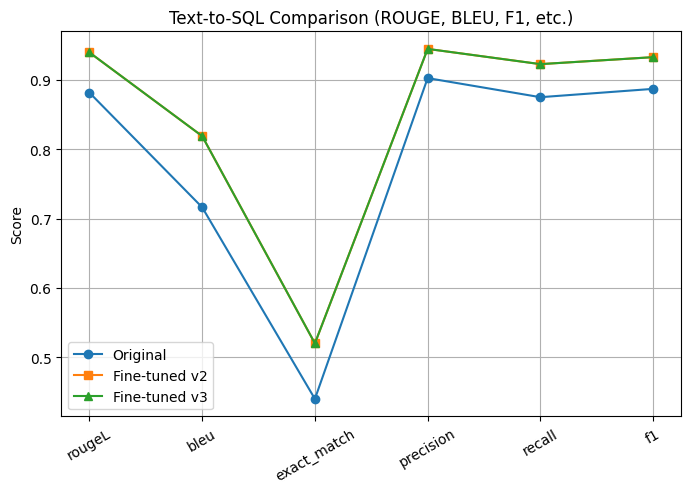

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,5))
labels   = list(m_orig.keys())
x        = np.arange(len(labels))
orig_vals= [m_orig[k] for k in labels]
ft2_vals = [m_ft2[k]  for k in labels]   # [CHANGED]
ft3_vals = [m_ft3[k]  for k in labels]   # [CHANGED]

plt.plot(x, orig_vals, marker='o', label='Original')
plt.plot(x, ft2_vals, marker='s', label='Fine-tuned v2')   # [CHANGED]
plt.plot(x, ft3_vals, marker='^', label='Fine-tuned v3')   # [CHANGED]

plt.xticks(x, labels, rotation=30)
plt.ylabel("Score")
plt.title("Text-to-SQL Comparison (ROUGE, BLEU, F1, etc.)")
plt.legend()
plt.grid(True)
plt.show()


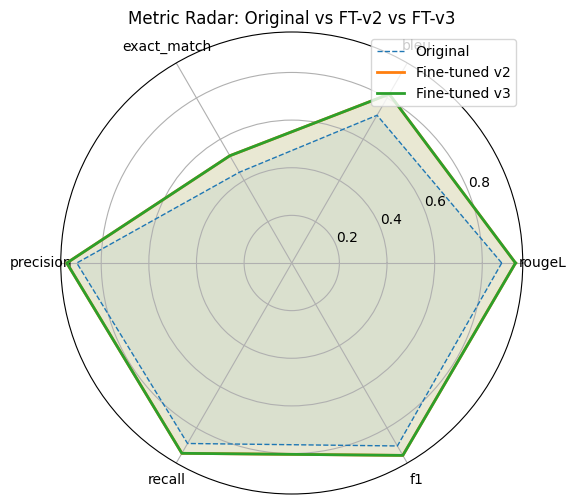

In [ ]:
from math import pi
import matplotlib.pyplot as plt

labels = list(m_ft3.keys())   # [CHANGED] dùng bộ khóa chung
orig = [m_orig[k] for k in labels]
ft2  = [m_ft2[k]  for k in labels]   # [CHANGED]
ft3  = [m_ft3[k]  for k in labels]   # [CHANGED]

angles = [n / float(len(labels)) * 2 * pi for n in range(len(labels))]
orig += orig[:1]; ft2 += ft2[:1]; ft3 += ft3[:1]; angles += angles[:1]   # [CHANGED]

fig, ax = plt.subplots(subplot_kw=dict(polar=True), figsize=(6,6))
ax.plot(angles, orig, '--', linewidth=1, label='Original');       ax.fill(angles, orig, alpha=0.08)
ax.plot(angles, ft2,  '-', linewidth=2, label='Fine-tuned v2');   ax.fill(angles, ft2,  alpha=0.10)
ax.plot(angles, ft3,  '-', linewidth=2, label='Fine-tuned v3');   ax.fill(angles, ft3,  alpha=0.10)

ax.set_xticks(angles[:-1]); ax.set_xticklabels(labels, fontsize=10)
ax.set_title("Metric Radar: Original vs FT-v2 vs FT-v3")
ax.legend(loc='upper right')
plt.show()


In [ ]:
out_df = pd.DataFrame([m_orig, m_ft], index=["Original", "Fine-tuned"])
out_df.to_csv("/kaggle/working/text2sql_eval_metrics.csv")
print("Saved metrics summary → /kaggle/working/text2sql_eval_metrics.csv")
out_df


In [ ]:
# ========================== CONFIG (bạn chỉ sửa phần này) ==========================
ORIG_DIR = "/kaggle/input/dt-olms-text2sql-ep1/sql_t5_finetuned"                    # model gốc
FT2_DIR  = "/kaggle/input/sql-t5-finetuned-v2/finetuned_model_2_epoch"              # model ep2  [CHANGED]
FT3_DIR  = "/kaggle/working/finetuned_model_3_epoch"                                # model ep3 mới train [CHANGED]

MODE = "custom"           # "custom" | "random_synth" | "sample_from_merged"

# -- Dùng khi MODE="custom"
CUSTOM_SCHEMA = """\
CREATE TABLE coupons (CouponId INT, Code NVARCHAR, DiscountAmount DECIMAL, ExpiryDate DATETIME2, IsActive BIT, CreatedAt DATETIME2, DiscountPercent INT, MaxUsageCount INT, UsageCount INT);
CREATE TABLE courses (CourseId INT, Title NVARCHAR, Description NVARCHAR, IsPaid BIT, Price DECIMAL, CreatedAt DATETIME2, ImageUrl NVARCHAR, ExpiryDate DATETIME2, InstructorId INT);
CREATE TABLE enrollments (EnrollmentId INT, UserId INT, CourseId INT, IsCompleted BIT, CompletionDate DATETIME2, CreatedAt DATETIME2, ProgressPercent REAL);
CREATE TABLE instructors (UserId INT, Specialization NVARCHAR, Bio NVARCHAR);
CREATE TABLE lessonprogress (ProgressId INT, UserId INT, LessonId INT, IsCompleted BIT, CompletedAt DATETIME2, LastUpdate DATETIME2);
CREATE TABLE lessons (LessonId INT, CourseId INT, LessonType NVARCHAR, Title NVARCHAR, CreatedAt DATETIME2, Duration INT);
CREATE TABLE payments (PaymentId INT, UserId INT, CourseId INT, Amount DECIMAL, TransactionId NVARCHAR, ResponseMessage NVARCHAR, CreatedAt DATETIME2, CouponId INT, Method NVARCHAR, OrderInfo NVARCHAR, Status NVARCHAR, OrderId NVARCHAR);
CREATE TABLE quizresults (ResultId INT, UserId INT, LessonId INT, Score INT, SubmittedAt DATETIME2, CorrectAnswers INT, TotalQuestions INT);
CREATE TABLE quizzes (QuizId INT, LessonId INT, Question NVARCHAR, OptionA NVARCHAR, OptionB NVARCHAR, OptionC NVARCHAR, OptionD NVARCHAR, CorrectAnswer INT, ImageUrl NVARCHAR);
CREATE TABLE textlessons (TextId INT, LessonId INT, Content NVARCHAR);
CREATE TABLE users (UserId INT, Name NVARCHAR, Email NVARCHAR, PasswordHash NVARCHAR, Role NVARCHAR, IsActive BIT, CreatedAt DATETIME2, RefreshToken NVARCHAR, RefreshTokenExpiry DATETIME2, AvatarUrl NVARCHAR);
CREATE TABLE videolessons (VideoId INT, LessonId INT, YoutubeUrl NVARCHAR);
CREATE TABLE communitymessages (MessageId INT, SenderId INT, Content NVARCHAR, Attachment NVARCHAR, CreatedAt DATETIME2);
CREATE TABLE conversationmembers (Id INT, ConversationId UNIQUEIDENTIFIER, UserId INT, Role NVARCHAR, JoinedAt DATETIME2, LastReadAt DATETIME2);
CREATE TABLE conversations (Id UNIQUEIDENTIFIER, Type NVARCHAR, Title NVARCHAR, CreatedByUserId INT, CreatedAt DATETIME2);
CREATE TABLE messageattachments (Id UNIQUEIDENTIFIER, MessageId UNIQUEIDENTIFIER, Url NVARCHAR, FileName NVARCHAR, FileSize BIGINT, ContentType NVARCHAR, Width INT, Height INT);
CREATE TABLE messages (Id UNIQUEIDENTIFIER, ConversationId UNIQUEIDENTIFIER, SenderId INT, Content NVARCHAR, MessageType NVARCHAR, ReplyToMessageId UNIQUEIDENTIFIER, CreatedAt DATETIME2, EditedAt DATETIME2, DeletedAt DATETIME2);
"""
CUSTOM_QUESTION = "Calculate the total number of quiz questions per lesson"
CUSTOM_EXPECTED = None     # có thể để None; nếu có, sẽ so exact_match

# -- Dùng khi MODE="sample_from_merged"
MERGED_DIR = "/kaggle/input/dt-olms-text2sql-ep1/merged_dataset"     # đã save_to_disk
SPLIT = "test"             # "test" | "validation" | "train"
INDEX = None               # nếu None → lấy ngẫu nhiên 1 mẫu trong split

# ============================= IMPLEMENTATION (không sửa) ==========================
import os, random, torch, pandas as pd, numpy as np
from datasets import load_from_disk
from transformers import T5ForConditionalGeneration, T5Tokenizer, GenerationConfig

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# [CHANGED] load 3 model + tokenizer
orig_model = T5ForConditionalGeneration.from_pretrained(ORIG_DIR).to(DEVICE).eval()
ft2_model  = T5ForConditionalGeneration.from_pretrained(FT2_DIR).to(DEVICE).eval()
ft3_model  = T5ForConditionalGeneration.from_pretrained(FT3_DIR).to(DEVICE).eval()
orig_tok   = T5Tokenizer.from_pretrained(ORIG_DIR)
ft2_tok    = T5Tokenizer.from_pretrained(FT2_DIR)
ft3_tok    = T5Tokenizer.from_pretrained(FT3_DIR)

gen_cfg    = GenerationConfig(max_new_tokens=300, do_sample=False)

def build_prompt(question:str, schema:str|None):
    if schema and schema.strip():
        return f"Tables:\n{schema.strip()}\n\nQuestion:\n{question.strip()}\n\nAnswer:\n"
    return f"translate to sql: {question.strip()}"

def synthesize_schema_and_question():
    TABLES = {
        "users":        ["id INT","name VARCHAR","email VARCHAR","role VARCHAR","created_at TIMESTAMP"],
        "courses":      ["id INT","title VARCHAR","price DECIMAL","instructor_id INT","created_at TIMESTAMP"],
        "instructors":  ["id INT","name VARCHAR","rating DECIMAL","joined_at DATE"],
        "enrollments":  ["id INT","user_id INT","course_id INT","purchased_at TIMESTAMP"],
        "orders":       ["id INT","user_id INT","amount DECIMAL","paid_at TIMESTAMP","status VARCHAR"],
        "coupons":      ["id INT","code VARCHAR","discount INT","expires_at DATE"],
        "progress":     ["id INT","user_id INT","course_id INT","lesson INT","done_at TIMESTAMP"]
    }
    k = random.randint(3,4)
    chosen = random.sample(list(TABLES.keys()), k)
    lines = []
    for t in chosen:
        cols = ", ".join(random.sample(TABLES[t], min(3, len(TABLES[t]))))
        lines.append(f"{t}({cols})")
    schema = "\n".join(lines)
    qs = [
        "show all courses with price greater than 50 ordered by price desc limit 5",
        "count users who enrolled in any course in the last 7 days",
        "list top 3 instructors by rating",
        "find total revenue by day in 2024",
        "show user name and course title for the most recent 5 enrollments",
        "list courses with active coupons",
        "how many orders are paid today",
    ]
    return schema, random.choice(qs)

def load_one_from_merged(dir_path, split, index=None):
    ds = load_from_disk(dir_path)
    data = ds[split] if split in ds else ds["validation"]
    cols = set(data.column_names)
    def pick(cands): 
        for c in cands:
            if c in cols: return c
        return None
    q_col = pick(["question","nl_question","input","utterance","Query","instruction"])
    a_col = pick(["answer","sql","sql_query","query","response"])
    c_col = pick(["context","schema","tables","db_schema","text"])

    i = index if (index is not None and 0 <= index < len(data)) else random.randrange(len(data))
    row = data.select([i])[0]
    question = str(row[q_col]); answer = str(row[a_col])
    context  = str(row[c_col]) if c_col and row.get(c_col) is not None else ""
    return question, answer, context

# -------- build test case ----------
if MODE == "custom":
    question = CUSTOM_QUESTION; context = CUSTOM_SCHEMA; expected = CUSTOM_EXPECTED
elif MODE == "random_synth":
    context, question = synthesize_schema_and_question(); expected = None
elif MODE == "sample_from_merged":
    question, expected, context = load_one_from_merged(MERGED_DIR, SPLIT, INDEX)
else:
    raise ValueError("MODE must be one of: custom | random_synth | sample_from_merged")

prompt = build_prompt(question, context)

def generate_sql(model, tok, prompt):
    ids = tok(prompt, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        out = model.generate(**ids, generation_config=gen_cfg)
    txt = tok.decode(out[0], skip_special_tokens=True).strip()
    return txt if txt.endswith(";") else txt + ";"

# [CHANGED] tạo 3 kết quả
orig_sql = generate_sql(orig_model, orig_tok, prompt)
ft2_sql   = generate_sql(ft2_model,  ft2_tok,  prompt)
ft3_sql   = generate_sql(ft3_model,  ft3_tok,  prompt)

def exact(a,b):
    if a is None: return None
    return int(str(a).strip().lower() == str(b).strip().lower())

row = {
    "mode": MODE,
    "question (input)": question,
    "context/schema": context,
    "expected (optional)": expected,
    "original_sql":  orig_sql,
    "finetuned_v2_sql": ft2_sql,   # [CHANGED]
    "finetuned_v3_sql": ft3_sql,   # [CHANGED]
    "exact_match_orig": exact(expected, orig_sql),
    "exact_match_v2":   exact(expected, ft2_sql),   # [CHANGED]
    "exact_match_v3":   exact(expected, ft3_sql),   # [CHANGED]
    "prompt_used": prompt
}
pd.set_option("display.max_colwidth", None)
display(pd.DataFrame([row])[[
    "mode","question (input)","context/schema","expected (optional)",
    "original_sql","finetuned_v2_sql","finetuned_v3_sql",
    "exact_match_orig","exact_match_v2","exact_match_v3"
]])

print("\n--- Prompt sent to model (exactly like training template) ---\n")
print(prompt)


Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 512). Running this sequence through the model will result in indexing errors


,mode,question (input),context/schema,expected (optional),original_sql,finetuned_v2_sql,finetuned_v3_sql,exact_match_orig,exact_match_v2,exact_match_v3
0,custom,Calculate the total number of quiz questions per lesson,"CREATE TABLE coupons (CouponId INT, Code NVARCHAR, DiscountAmount DECIMAL, ExpiryDate DATETIME2, IsActive BIT, CreatedAt DATETIME2, DiscountPercent INT, MaxUsageCount INT, UsageCount INT);\nCREATE TABLE courses (CourseId INT, Title NVARCHAR, Description NVARCHAR, IsPaid BIT, Price DECIMAL, CreatedAt DATETIME2, ImageUrl NVARCHAR, ExpiryDate DATETIME2, InstructorId INT);\nCREATE TABLE enrollments (EnrollmentId INT, UserId INT, CourseId INT, IsCompleted BIT, CompletionDate DATETIME2, CreatedAt DATETIME2, ProgressPercent REAL);\nCREATE TABLE instructors (UserId INT, Specialization NVARCHAR, Bio NVARCHAR);\nCREATE TABLE lessonprogress (ProgressId INT, UserId INT, LessonId INT, IsCompleted BIT, CompletedAt DATETIME2, LastUpdate DATETIME2);\nCREATE TABLE lessons (LessonId INT, CourseId INT, LessonType NVARCHAR, Title NVARCHAR, CreatedAt DATETIME2, Duration INT);\nCREATE TABLE payments (PaymentId INT, UserId INT, CourseId INT, Amount DECIMAL, TransactionId NVARCHAR, ResponseMessage NVARCHAR, CreatedAt DATETIME2, CouponId INT, Method NVARCHAR, OrderInfo NVARCHAR, Status NVARCHAR, OrderId NVARCHAR);\nCREATE TABLE quizresults (ResultId INT, UserId INT, LessonId INT, Score INT, SubmittedAt DATETIME2, CorrectAnswers INT, TotalQuestions INT);\nCREATE TABLE quizzes (QuizId INT, LessonId INT, Question NVARCHAR, OptionA NVARCHAR, OptionB NVARCHAR, OptionC NVARCHAR, OptionD NVARCHAR, CorrectAnswer INT, ImageUrl NVARCHAR);\nCREATE TABLE textlessons (TextId INT, LessonId INT, Content NVARCHAR);\nCREATE TABLE users (UserId INT, Name NVARCHAR, Email NVARCHAR, PasswordHash NVARCHAR, Role NVARCHAR, IsActive BIT, CreatedAt DATETIME2, RefreshToken NVARCHAR, RefreshTokenExpiry DATETIME2, AvatarUrl NVARCHAR);\nCREATE TABLE videolessons (VideoId INT, LessonId INT, YoutubeUrl NVARCHAR);\nCREATE TABLE communitymessages (MessageId INT, SenderId INT, Content NVARCHAR, Attachment NVARCHAR, CreatedAt DATETIME2);\nCREATE TABLE conversationmembers (Id INT, ConversationId UNIQUEIDENTIFIER, UserId INT, Role NVARCHAR, JoinedAt DATETIME2, LastReadAt DATETIME2);\nCREATE TABLE conversations (Id UNIQUEIDENTIFIER, Type NVARCHAR, Title NVARCHAR, CreatedByUserId INT, CreatedAt DATETIME2);\nCREATE TABLE messageattachments (Id UNIQUEIDENTIFIER, MessageId UNIQUEIDENTIFIER, Url NVARCHAR, FileName NVARCHAR, FileSize BIGINT, ContentType NVARCHAR, Width INT, Height INT);\nCREATE TABLE messages (Id UNIQUEIDENTIFIER, ConversationId UNIQUEIDENTIFIER, SenderId INT, Content NVARCHAR, MessageType NVARCHAR, ReplyToMessageId UNIQUEIDENTIFIER, CreatedAt DATETIME2, EditedAt DATETIME2, DeletedAt DATETIME2);\n",None,SELECT COUNT(*) FROM questions AS T1 JOIN instructor AS T2 ON T1.UserId = T2.UserId WHERE T2.Name = 'Ph.' AND T2.Name = 'Ph.Name' AND T2.Name = 'Ph.Name';,SELECT COUNT(*) FROM questions AS T1 JOIN answers AS T2 ON T1.Id = T2.Id WHERE T2.Score >= 100 AND T2.Score >= 100;,"SELECT l.Title, COUNT(qr.ResultId) AS QuizCount FROM lessons l JOIN quizresults qr ON l.LessonId = qr.LessonId JOIN courses c ON l.CourseId = c.CourseId WHERE l.LessonType = 'Quiz' GROUP BY l.LessonId, l.Title ORDER BY TotalQuizQuestions DESC;",None,None,None



--- Prompt sent to model (exactly like training template) ---

Tables:
CREATE TABLE coupons (CouponId INT, Code NVARCHAR, DiscountAmount DECIMAL, ExpiryDate DATETIME2, IsActive BIT, CreatedAt DATETIME2, DiscountPercent INT, MaxUsageCount INT, UsageCount INT);
CREATE TABLE courses (CourseId INT, Title NVARCHAR, Description NVARCHAR, IsPaid BIT, Price DECIMAL, CreatedAt DATETIME2, ImageUrl NVARCHAR, ExpiryDate DATETIME2, InstructorId INT);
CREATE TABLE enrollments (EnrollmentId INT, UserId INT, CourseId INT, IsCompleted BIT, CompletionDate DATETIME2, CreatedAt DATETIME2, ProgressPercent REAL);
CREATE TABLE instructors (UserId INT, Specialization NVARCHAR, Bio NVARCHAR);
CREATE TABLE lessonprogress (ProgressId INT, UserId INT, LessonId INT, IsCompleted BIT, CompletedAt DATETIME2, LastUpdate DATETIME2);
CREATE TABLE lessons (LessonId INT, CourseId INT, LessonType NVARCHAR, Title NVARCHAR, CreatedAt DATETIME2, Duration INT);
CREATE TABLE payments (PaymentId INT, UserId INT, CourseId INT, A

In [ ]:
# Cài đặt thư viện datasets nếu chưa có
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 42.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 19.0.1
    Uninstalling pyarrow-19.0.1:
      Successfully uninstalled pyarrow-19.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
bigframes 2.12.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.1.

In [ ]:
# Cài đặt thư viện evaluate
!pip install evaluate 


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00


# ==============================
# 2) IMPORT CÁC THƯ VIỆN CẦN THIẾT
# ==============================

In [ ]:
import torch; 
print(torch.__version__, torch.cuda.is_available())

2.6.0+cu124 True


In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, load_dataset, interleave_datasets, load_from_disk # Dataset Huggingface
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer # Model và Tokenizer cho trainning
import torch # Thư viện PyTorch tăng tốc độ xử lý GPU, tensor
import time # Ghi thời gian trainning
import evaluate # Thư viện evaluate để đánh giá mô hình (BLEU, ROUGE)
import pandas as pd # Thư viện pandas để xử lý dữ liệu dạng bảng/kết quả
import numpy as np # Thư viện numpy để xử lý mảng


import warnings
warnings.filterwarnings("ignore") # Bỏ qua các cảnh báo không cần thiết

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Import thư viện transformers và huggingface_hub
!pip install transformers huggingface_hub 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 8.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 1.0.0rc2
    Uninstalling huggingface-hub-1.0.0rc2:
      Successfully uninstalled huggingface-hub-1.0.0rc2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.38.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.0a1 which is incompatible.


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration # Model và Tokenizer T5

import os # Thư viện os để thao tác với hệ thống tệp

# ==============================
# 3) CẤU HÌNH ĐƯỜNG DẪN VÀ THIẾT BỊ
# ==============================

In [ ]:
drive_model_path = '/kaggle/working/' # Đường dẫn lưu model trên Kaggle

In [ ]:
torch.cuda.is_available() # Kiểm tra GPU có sẵn không, trả về True hoặc False

True

In [ ]:
from huggingface_hub import snapshot_download

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1) Tải snapshot repo model về LOCAL FOLDER (chỉ gọi API 1 lần, không đụng 'additional_chat_templates')
#   - repo_id 't5-small' sẽ redirect về 'google-t5/t5-small'
local_dir = snapshot_download(repo_id="t5-small") 

Fetching 20 files:   0%|          | 0/20 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/537 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.47k [00:00<?, ?B/s]

flax_model.msgpack:   0%|          | 0.00/242M [00:00<?, ?B/s]

onnx/decoder_model.onnx:   0%|          | 0.00/232M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

onnx/decoder_model_merged.onnx:   0%|          | 0.00/233M [00:00<?, ?B/s]

onnx/decoder_model_quantized.onnx:   0%|          | 0.00/58.4M [00:00<?, ?B/s]

onnx/decoder_model_merged_quantized.onnx:   0%|          | 0.00/58.7M [00:00<?, ?B/s]

onnx/decoder_with_past_model.onnx:   0%|          | 0.00/220M [00:00<?, ?B/s]

onnx/decoder_with_past_model_quantized.o(…):   0%|          | 0.00/55.2M [00:00<?, ?B/s]

onnx/encoder_model.onnx:   0%|          | 0.00/141M [00:00<?, ?B/s]

onnx/encoder_model_quantized.onnx:   0%|          | 0.00/35.5M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

rust_model.ot:   0%|          | 0.00/242M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/242M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

In [ ]:
model_name='t5-small' # Tên model nền; code gốc chọn t5-small cho baseline/finetune

# tokenizer = T5Tokenizer.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(local_dir, local_files_only=True)

# Trên Kaggle GPU có thể dùng bfloat16, còn local CPU thì để mặc định FP32
if device == "cuda":
    original_model = T5ForConditionalGeneration.from_pretrained(
        model_name, torch_dtype=torch.bfloat16
    ).to(device)
else:
    original_model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

import warnings
warnings.filterwarnings("ignore", message="You are using the default legacy behaviour")


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


# ==============================
# 4) NẠP/CHUẨN BỊ DATASET (CÓ CACHE)
# ==============================

In [ ]:
# Cố gắng nạp dataset đã merge sẵn từ cache "merged_dataset" để tiết kiệm thời gian
try:
    dataset = load_from_disk("merged_dataset")
    print("Loaded Merged Dataset")
except:
    # Nếu không có cache, tiến hành tải và merge 3 dataset công khai và chia split thủ công
    
    # 4.1) b-mc2/sql-create-context (chứa question/context/answer)
    dataset_scc_train = load_dataset("b-mc2/sql-create-context", split='train[:80%]') # 80% train
    dataset_scc_test  = load_dataset("b-mc2/sql-create-context", split='train[-20%:-10%]') # 10% test
    dataset_scc_val   = load_dataset("b-mc2/sql-create-context", split='train[-10%:]') # 10% validation

    # 4.2) Clinton/Text-to-sql-v1 (đổi tên cột để thống nhất question/context/answer)

    dataset_tts_train = load_dataset("Clinton/Text-to-sql-v1", split='train[:80%]') # 80% train
    dataset_tts_train = dataset_tts_train.remove_columns(['source', 'text']) # Bỏ cột không cần thiết
    dataset_tts_train = dataset_tts_train.rename_columns({'instruction': 'question', 'input': 'context', 'response': 'answer'}) # Đổi tên cột cho thống nhất với dataset_scc
    
    dataset_tts_test  = load_dataset("Clinton/Text-to-sql-v1", split='train[-20%:-10%]') # 10% test
    dataset_tts_test  = dataset_tts_test.remove_columns(['source', 'text']) 
    dataset_tts_test  = dataset_tts_test.rename_columns({'instruction': 'question', 'input': 'context', 'response': 'answer'}) 
    dataset_tts_val   = load_dataset("Clinton/Text-to-sql-v1", split='train[-10%:]') # 10% validation
    dataset_tts_val   = dataset_tts_val.remove_columns(['source', 'text'])
    dataset_tts_val   = dataset_tts_val.rename_columns({'instruction': 'question', 'input': 'context', 'response': 'answer'})

    # 4.3) knowrohit07/know_sql (đổi tên cột để thống nhất question/context/answer)
    dataset_ks_train  = load_dataset("knowrohit07/know_sql", split='validation[:80%]')
    dataset_ks_test   = load_dataset("knowrohit07/know_sql", split='validation[-20%:-10%]')
    dataset_ks_val    = load_dataset("knowrohit07/know_sql", split='validation[-10%:]')

    # 4.4) Ghép 3 nguồn lại bằng interleave_datasets để tăng đa dạng dữ liệu
    dataset = DatasetDict({ 'train': interleave_datasets([dataset_scc_train, dataset_tts_train, dataset_ks_train]),
                            'test': interleave_datasets([dataset_scc_test, dataset_tts_test, dataset_ks_test]),
                            'validation': interleave_datasets([dataset_scc_val, dataset_tts_val, dataset_ks_val])})

    # Lưu dataset đã merge vào cache "merged_dataset" để lần sau dùng lại
    dataset.save_to_disk("merged_dataset")
    print("Merged and Saved Dataset")

dataset # Hiển thị thông tin dataset

README.md: 0.00B [00:00, ?B/s]

sql_create_context_v4.json:   0%|          | 0.00/21.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/78577 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/118 [00:00<?, ?B/s]

texttosqlv2.jsonl:   0%|          | 0.00/635M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/262208 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

know_sql_val3{ign}.json:   0%|          | 0.00/13.5M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/49456 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/118695 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/14835 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/14838 [00:00<?, ? examples/s]

Merged and Saved Dataset


DatasetDict({
    train: Dataset({
        features: ['answer', 'question', 'context'],
        num_rows: 118695
    })
    test: Dataset({
        features: ['answer', 'question', 'context'],
        num_rows: 14835
    })
    validation: Dataset({
        features: ['answer', 'question', 'context'],
        num_rows: 14838
    })
})

In [ ]:
dataset['test'][0:8] # Kiểm tra một mẫu trong tập test

{'answer': ['SELECT date FROM table_name_11 WHERE away_team = "essendon"',
  'SELECT institution FROM table_1974632_1 WHERE location = "Glenside, Pennsylvania"',
  'SELECT home_team FROM table_name_4 WHERE away_team = "hereford united"',
  'SELECT date FROM table_name_49 WHERE home_team = "north melbourne"',
  'SELECT "Character" FROM table_79388 WHERE "Duration" = \'13 years\' AND "Actor" = \'vicky versavel\'',
  'SELECT clubs FROM table_name_59 WHERE position_in_1959_1960 = "1"',
  'SELECT record FROM table_name_72 WHERE date = "september 1"',
  "SELECT DISTINCT flight.flight_id FROM airport_service AS AIRPORT_SERVICE_0, airport_service AS AIRPORT_SERVICE_1, city AS CITY_0, city AS CITY_1, days, flight WHERE ((((flight.departure_time <= 2359 AND flight.departure_time >= 1800) AND days.day_name = 'WEDNESDAY' AND flight.flight_days = days.days_code) OR ((flight.departure_time <= departure_time2 AND flight.departure_time >= departure_time3) AND days.day_name = 'day_name1' AND flight.fli

# ==============================
# 5) HÀM TIỀN XỬ LÝ (TOKENIZE) + TẠO PROMPT
# ==============================

Ở bước này, cần chuyển đổi các bộ dữ liệu thành dạng hướng dẫn rõ ràng cho mô hình ngôn ngữ lớn (LLM).

Sau đó, tiến hành tiền xử lý dữ liệu prompt-response bằng cách mã hóa (tokenize) để lấy ra các input_ids phục vụ cho quá trình huấn luyện.

Ghi chú: Chuyển dữ liệu dạng (context/question/answer) → (input_ids/labels) cho T5
 Prompt dạng:
 Tables:\n{context}\n\nQuestion:\n{question}\n\nAnswer:\n

In [ ]:
# def tokenize_function(example): # Hàm tokenize_function để tiền xử lý dữ liệu

# #     print(len(example["question"]))
# # # Tiền tố/giữa/hậu cho prompt để mô hình rõ cấu trúc đầu vào
#     start_prompt = "Tables:\n" # Bắt đầu với Tables:
#     middle_prompt = "\n\nQuestion:\n" # Giữa là Question:
#     end_prompt = "\n\nAnswer:\n" # Kết thúc với Answer:

#     # Ghép promt theo từng cặp context/question
#     data_zip = zip(example['context'], example['question']) # Ghép cặp context và question
#     prompt = [start_prompt + context + middle_prompt + question + end_prompt for context, question in data_zip] # Tạo prompt hoàn chỉnh
    
#     # Mã hoá prompt → input_ids (padding/truncation theo mặc định max_length của tokenizer)
#     example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids # Tokenize prompt
    
#     # Mã hoá câu trả lời (answer) → labels
#     example['labels'] = tokenizer(example['answer'], padding="max_length", truncation=True, return_tensors="pt").input_ids # Tokenize answer
# #     print(prompt[0])
# #     print()

#     return example

# # Ghi chú: Hàm trên sẽ được áp vào cả 3 split (train/validation/test) bằng map(batched=True)
# # batched=True để xử lý theo lô, tăng tốc độ xử lý
# # Hàm tokenize_function xử lý tất cả dữ liệu trên tất cả các split theo lô.


# # Cố gắng nạp dataset đã tokenized sẵn từ cache "tokenized_datasets" để tiết kiệm thời gian
# try:
#     # Thử nạp từ cache nếu đã tokenized trước đó
#     tokenized_datasets = load_from_disk("tokenized_datasets") 
#     print("Loaded Tokenized Dataset")
# except:
#     # Nếu chưa có cache, thực thi map → loại bỏ cột thừa → lưu cache
#     tokenized_datasets = dataset.map(tokenize_function, batched=True) # Áp dụng hàm tokenize_function cho toàn bộ dataset
#     tokenized_datasets = tokenized_datasets.remove_columns(['question', 'context', 'answer']) # Loại bỏ cột thừa để tiết kiệm bộ nhớ

#     # Lưu dataset đã tokenized vào cache "tokenized_datasets" để lần sau dùng lại
#     tokenized_datasets.save_to_disk("tokenized_datasets")
#     print("Tokenized and Saved Dataset")
from transformers import DataCollatorForSeq2Seq

MAX_INPUT_LEN = 256   # độ dài tối đa của prompt (Tables + Question)
MAX_LABEL_LEN = 128   # độ dài tối đa của Answer/SQL

def tokenize_function(example):
    # Tạo prompt chuẩn dạng:
    # Tables: [schema]
    # Question: [natural language question]
    # Answer: [SQL query]
    start_prompt = "Tables:\n"
    middle_prompt = "\n\nQuestion:\n"
    end_prompt = "\n\nAnswer:\n"

    # Ghép từng cặp context + question thành một prompt hoàn chỉnh
    prompt = [
        start_prompt + context + middle_prompt + question + end_prompt
        for context, question in zip(example["context"], example["question"])
    ]

    # Tokenize đầu vào và đầu ra với padding động + cắt độ dài hợp lý
    model_inputs = tokenizer(
        prompt,
        padding=False,  # 🔻 không ép về max_length
        truncation=True,
        max_length=MAX_INPUT_LEN,
    )

    labels = tokenizer(
        example["answer"],
        padding=False,
        truncation=True,
        max_length=MAX_LABEL_LEN,
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


# =========================================================
# 🔹 TẠO DATASET TOKENIZED (CÓ CACHE)
# =========================================================
try:
    tokenized_datasets = load_from_disk("tokenized_datasets")
    print("✅ Loaded tokenized dataset from cache.")
except:
    tokenized_datasets = dataset.map(
        tokenize_function, batched=True, remove_columns=["question", "context", "answer"]
    )
    tokenized_datasets.save_to_disk("tokenized_datasets")
    print("✅ Tokenized dataset saved to cache.")

# Data collator → tự padding theo batch, giúp tiết kiệm VRAM
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=finetuned_model,
    padding="longest",
)

Map:   0%|          | 0/118695 [00:00<?, ? examples/s]

Map:   0%|          | 0/14835 [00:00<?, ? examples/s]

Map:   0%|          | 0/14838 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/118695 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/14835 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/14838 [00:00<?, ? examples/s]

✅ Tokenized dataset saved to cache.


NameError: name 'finetuned_model' is not defined

In [ ]:
# Hiển thị thông tin tokenized_datasets kiểm tra nhanh khóa/cấu trúc trước khi train
print(tokenized_datasets.keys()) # Hiển thị các split có trong tokenized_datasets
print(tokenized_datasets['train'][0].keys()) # Hiển thị các khóa trong một mẫu của tập train
print(tokenized_datasets['train'][0]['input_ids'][:10]) # Hiển thị 10 token đầu tiên của input_ids
print(tokenized_datasets['train'][0]['labels'][:10]) # Hiển thị 10 token đầu tiên của labels
print(tokenized_datasets) # Hiển thị thông tin dataset

dict_keys(['train', 'test', 'validation'])
dict_keys(['input_ids', 'labels'])
[4398, 7, 10, 205, 4386, 6048, 332, 17098, 819, 41]
[3, 23143, 14196, 2847, 17161, 599, 1935, 61, 21680, 819]
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 118695
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 14835
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 14838
    })
})


In [ ]:
print(f"Shapes of the datasets:")
print(f"Training: {tokenized_datasets['train'].shape}") # In kích thước tập train (số mẫu, số cột)
print(f"Validation: {tokenized_datasets['validation'].shape}") # In kích thước tập validation (số mẫu, số cột)
print(f"Test: {tokenized_datasets['test'].shape}") # In kích thước tập test (số mẫu, số cột)

print(tokenized_datasets) # Hiển thị thông tin tokenized_datasets

Shapes of the datasets:
Training: (118695, 2)
Validation: (14838, 2)
Test: (14835, 2)
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 118695
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 14835
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 14838
    })
})


# ==============================
# 7) KIỂM THỬ ZERO-SHOT VỚI MODEL GỐC (BASELINE)
# ==============================

In [ ]:
import torch # Thư viện PyTorch tăng tốc độ xử lý GPU, tensor

# Định nghĩa prompt & answer mẫu để test nhanh (người dùng cần thay bằng ví dụ thật)
prompt = "Your input prompt here"  # Ví dụ: Tables + Question (cần thay bằng prompt thực)
answer = "Expected human response here"  # Ví dụ: câu SQL chuẩn tương ứng (đáp án chuẩn)

# Đảm bảo model và input cùng trên một thiết bị (CPU hoặc GPU) nếu có
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Di chuyển model sang thiết bị phù hợp (device = CPU hoặc GPU)
original_model.to(device)

# Tokenize đầu vào input và chuyển nó sang cùng thiết bị với model
inputs = tokenizer(prompt, return_tensors='pt').to(device)

# Sinh đầu ra zero-shot từ model gốc (chưa fine-tune)
output = tokenizer.decode( # dùng tokenizer.decode để giải mã token thành text
    original_model.generate( # dùng phương thức generate để sinh text
        inputs["input_ids"], # input_ids của prompt đã tokenized
        max_new_tokens=200, # Giới hạn tối đa 200 token mới sinh
    )[0], # Lấy mảng token đầu tiên trong batch (ở đây batch size=1)
    skip_special_tokens=True # Bỏ qua các token đặc biệt khi giải mã
)

# In kết quả zero-shot baseline
dash_line = '-' * 100 
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}') 
print(dash_line)
print(f'BASELINE HUMAN ANSWER:\n{answer}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')


----------------------------------------------------------------------------------------------------
INPUT PROMPT:
Your input prompt here
----------------------------------------------------------------------------------------------------
BASELINE HUMAN ANSWER:
Expected human response here

----------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
Votre prompt here


# ==============================
# 8) HUẤN LUYỆN FULL FINE-TUNE (KAGGLE GPU)
# ==============================

#### 5e-3

Thời gian huấn luyện      = 2 giờ 49 phút 1 giây trên laptop sử dụng notebook Kaggle (PC cá nhân không đủ bộ nhớ CUDA để huấn luyện với tập dữ liệu lớn)

Training Loss   = 0.023100

Validation Loss = 0.013285

---

**Giải thích:**

- **5e-3**: Đây là giá trị learning rate (tốc độ học) được sử dụng khi huấn luyện mô hình. Giá trị này ảnh hưởng đến tốc độ cập nhật trọng số của mô hình trong quá trình học.
- **Thời gian huấn luyện**: Tổng thời gian để hoàn thành quá trình fine-tune mô hình trên GPU của Kaggle. Nếu dùng máy cá nhân (PC) không có đủ bộ nhớ CUDA thì sẽ không thể huấn luyện với tập dữ liệu lớn.
- **Training Loss**: Độ lỗi (loss) trên tập huấn luyện. Giá trị càng nhỏ chứng tỏ mô hình học tốt trên dữ liệu huấn luyện.
- **Validation Loss**: Độ lỗi trên tập kiểm thử (validation). Giá trị này dùng để đánh giá khả năng tổng quát hóa của mô hình trên dữ liệu chưa từng thấy. Nếu validation loss thấp và gần với training loss, mô hình không bị overfit.

**Kết luận:**  
Mô hình đã được huấn luyện với tốc độ học 5e-3, thời gian gần 3 tiếng trên GPU của Kaggle. Kết quả training loss và validation loss đều thấp, chứng tỏ mô hình học tốt và có khả năng tổng quát hóa tốt trên dữ liệu kiểm thử.

In [ ]:
# Nếu trước đó bạn đã dùng snapshot_download(...) và có biến local_dir,
# thì ưu tiên nạp model/tokenizer từ local_dir; nếu không thì dùng tên model gốc.
base_source = local_dir if 'local_dir' in globals() else model_name  # ví dụ: "google-t5/t5-small" hoặc "t5-small"


# ===== Cố gắng nạp model đã fine-tune nếu có =====
try:
    # Nạp lại mô hình đã fine-tune (thư mục local do bạn save_pretrained trước đó)
    finetuned_model = T5ForConditionalGeneration.from_pretrained("finetuned_model_2_epoch").to(device)

    # Nạp tokenizer đi kèm checkpoint fine-tune (đảm bảo đồng bộ vocab)
    tokenizer = T5Tokenizer.from_pretrained("finetuned_model_2_epoch")

    to_train = False  # Có model rồi → không cần train lại

except Exception as e:
    # Không có checkpoint fine-tune → nạp model nền để fine-tune
    to_train = True

    if device == "cuda":
        # Trên Kaggle GPU có thể dùng bfloat16 để tiết kiệm VRAM/tăng tốc
        finetuned_model = T5ForConditionalGeneration.from_pretrained(
            base_source, torch_dtype=torch.bfloat16
        ).to(device)
    else:
        # Trên CPU giữ FP32 mặc định
        finetuned_model = T5ForConditionalGeneration.from_pretrained(base_source).to(device)

    # Tokenizer đồng bộ với nguồn model nền (từ local_dir nếu có, hoặc từ tên model)
    tokenizer = T5Tokenizer.from_pretrained(base_source)

In [ ]:

import os, time, torch
from transformers import TrainingArguments, Trainer

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
finetuned_model.config.use_cache = False  #  tắt cache để tránh giữ tensor lớn
finetuned_model.gradient_checkpointing_enable()  #  chia nhỏ graph tính toán

if to_train:
    output_dir = f"./sql-training-{int(time.time())}"

    training_args = TrainingArguments(
        output_dir=output_dir, # Thư mục lưu kết quả huấn luyện
        learning_rate=5e-3,# Tốc độ học của mô hình
        num_train_epochs=1, # Số epoch huấn luyện
        per_device_train_batch_size=4,   # batch size nhỏ để phù hợp với VRAM (huấn luyện)
        per_device_eval_batch_size=4, # batch size nhỏ để phù hợp với VRAM (đánh giá)
        gradient_accumulation_steps=4,   # cộng dồn gradient để mô phỏng batch size lớn hơn
        weight_decay=0.01, # Hệ số weight decay để tránh overfitting (thường chọn 0.01)
        logging_steps=50, # Ghi log mỗi 50 bước
        eval_strategy="no", # tắt eval trong lúc train cho nhẹ
        save_strategy="epoch", # lưu model mỗi epoch
        fp16=True, # mix precision để tiết kiệm VRAM
        optim="adafactor", # tối ưu hóa Adafactor tiết kiệm bộ nhớ
        report_to="none", # tắt Weights & Biases để tránh lỗi trên Kaggle
    )

    trainer = Trainer(
        model=finetuned_model, # Mô hình cần huấn luyện
        args=training_args, # Tham số huấn luyện đã cấu hình
        data_collator=data_collator, # Hàm collate để padding theo batch
        train_dataset=tokenized_datasets["train"], # Dữ liệu huấn luyện
    )

    # Dọn sạch cache GPU trước khi train
    torch.cuda.empty_cache()
    trainer.train()

    print("✅ Training completed successfully!")
    finetuned_model.save_pretrained("finetuned_model_2_epoch")
    tokenizer.save_pretrained("finetuned_model_2_epoch")

Step,Training Loss
50,0.349100
100,0.084300
150,0.066800
200,0.052000
250,0.055800
300,0.050200
350,0.048700
400,0.046900
450,0.043600
500,0.039700


✅ Training completed successfully!


In [ ]:
# Dù đã fine-tune hay chưa, vẫn lưu model/tokenizer vào thư mục làm việc của Kaggle để tải về
finetuned_model.save_pretrained("/kaggle/working/sql_t5_finetuned") # Lưu model đã fine-tune vào thư mục làm việc của Kaggle
tokenizer.save_pretrained("/kaggle/working/sql_t5_finetuned") # Lưu tokenizer vào thư mục làm việc của Kaggle


('/kaggle/working/sql_t5_finetuned/tokenizer_config.json',
 '/kaggle/working/sql_t5_finetuned/special_tokens_map.json',
 '/kaggle/working/sql_t5_finetuned/spiece.model',
 '/kaggle/working/sql_t5_finetuned/added_tokens.json')

In [ ]:
# Hiển thị model đã fine-tune (hoặc model gốc nếu chưa fine-tune)
print("Model:", finetuned_model) 


Model: T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout

# ==============================
# 9) KIỂM THỬ MÔ HÌNH ĐÃ FINE-TUNE (ZERO-SHOT TRÊN MẪU)
# ==============================

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Chuẩn bị model đã fine-tune để suy luận
finetuned_model.gradient_checkpointing_disable()  # tắt checkpointing khi inference
finetuned_model.config.use_cache = True           # bật lại cache cho generate nhanh
finetuned_model.eval()
finetuned_model.to(device)

# (tùy chọn với baseline)
original_model.gradient_checkpointing_disable() if hasattr(original_model, "gradient_checkpointing_disable") else None
try:
    original_model.config.use_cache = True
except:
    pass
original_model.eval()
original_model.to(device)


T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [ ]:
index = 0
question = dataset['test'][index]['question']
context  = dataset['test'][index]['context']
answer   = dataset['test'][index]['answer']

prompt = f"""Tables:
{context}

Question:
{question}

Answer:
"""

# Tokenize 'prompt' (chuỗi được tạo từ context + question) thành tensors PyTorch
# - Nguồn dữ liệu: `prompt` (lấy từ dataset['test'][index]['context'] và ['question'])
# - Input: prompt (str), tokenizer (T5Tokenizer), device ('cuda' hoặc 'cpu')
# - Output: inputs (dict) chứa 'input_ids' và 'attention_mask' dưới dạng torch.Tensor đã được chuyển lên device
inputs = tokenizer(prompt, return_tensors='pt').to(device)

with torch.no_grad():
    output_tokens = finetuned_model.generate( # dùng phương thức generate để sinh text
        inputs["input_ids"], # input_ids của prompt đã tokenized
        max_new_tokens=200, # Giới hạn tối đa 200 token mới sinh
    )

output_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True) # Giải mã token thành text, bỏ qua token đặc biệt

print("-"*80)
print("INPUT PROMPT:\n", prompt)
print("-"*80)
print("BASELINE HUMAN ANSWER:\n", answer, "\n")
print("-"*80)
print("FINE-TUNED MODEL - ZERO SHOT:\n", output_text)


--------------------------------------------------------------------------------
INPUT PROMPT:
 Tables:
CREATE TABLE table_name_11 (date VARCHAR, away_team VARCHAR)

Question:
On what Date did the Away team essendon play?

Answer:

--------------------------------------------------------------------------------
BASELINE HUMAN ANSWER:
 SELECT date FROM table_name_11 WHERE away_team = "essendon" 

--------------------------------------------------------------------------------
FINE-TUNED MODEL - ZERO SHOT:
 SELECT date FROM table_name_11 WHERE away_team = "essendon"


# ==============================
# 10) ĐÁNH GIÁ SƠ BỘ BẰNG ROUGE (SUBSET 25 MẪU)
# ==============================
 Ghi chú: ROUGE đo độ “giống” chuỗi, không phải thước đo chuẩn cho SQL (Exec-Acc), nhưng dùng ở đây như chỉ báo tham khảo nhanh.


Các bước phía dưới sẽ thực hiện đánh giá định lượng mô hình đã fine-tune bằng metric ROUGE trên một tập mẫu nhỏ (25 mẫu) để so sánh chất lượng sinh SQL giữa model gốc và model đã huấn luyện.  
Sau đó, hướng dẫn cách sử dụng mô hình đã fine-tune để sinh truy vấn SQL mới (inference), và đóng gói mô hình thành file zip để tiện tải về hoặc triển khai vào ứng dụng thực tế (FastAPI, Flask, .NET...).

**Tóm tắt các bước:**
1. Đánh giá mô hình bằng ROUGE (so sánh với đáp án chuẩn).
2. Sinh truy vấn SQL mới từ mô hình đã fine-tune (inference).

In [ ]:
from transformers import GenerationConfig
import pandas as pd

questions = dataset['test'][0:25]['question']
contexts  = dataset['test'][0:25]['context']
human_baseline_answers = dataset['test'][0:25]['answer']

original_model_answers  = []
finetuned_model_answers = []

gen_cfg = GenerationConfig(max_new_tokens=300)

with torch.no_grad():
    for q, c in zip(questions, contexts):
        prompt = f"""Tables:
{c}

Question:
{q}

Answer:
"""
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

        # Baseline
        out_base = original_model.generate(input_ids=input_ids, generation_config=gen_cfg)
        original_model_answers.append(tokenizer.decode(out_base[0], skip_special_tokens=True))

        # Fine-tuned
        out_ft = finetuned_model.generate(input_ids=input_ids, generation_config=gen_cfg)
        finetuned_model_answers.append(tokenizer.decode(out_ft[0], skip_special_tokens=True))

df = pd.DataFrame(
    zip(human_baseline_answers, original_model_answers, finetuned_model_answers),
    columns=["human_baseline_answers", "original_model_answers", "finetuned_model_answers"]
)

display(df)  # nếu muốn xem bảng

,human_baseline_answers,original_model_answers,finetuned_model_answers
0,SELECT date FROM table_name_11 WHERE away_team...,Question,SELECT date FROM table_name_11 WHERE away_team...
1,SELECT institution FROM table_1974632_1 WHERE ...,"Question: state the institution in glenside, p...",SELECT institution FROM table_1974632_1 WHERE ...
2,SELECT home_team FROM table_name_4 WHERE away_...,True,SELECT home_team FROM table_name_4 WHERE away_...
3,SELECT date FROM table_name_49 WHERE home_team...,Question,SELECT date FROM table_name_49 WHERE home_team...
4,"SELECT ""Character"" FROM table_79388 WHERE ""Dur...",True,"SELECT ""Character"" FROM table_79388 WHERE ""Yea..."
5,SELECT clubs FROM table_name_59 WHERE position...,Question,SELECT clubs FROM table_name_59 WHERE position...
6,SELECT record FROM table_name_72 WHERE date = ...,Question,SELECT record FROM table_name_72 WHERE date = ...
7,SELECT DISTINCT flight.flight_id FROM airport_...,"CREATE TABLE flight_leg ( flight_id int, leg_n...",SELECT DISTINCT flight.flight_id FROM airport_...
8,SELECT season_joined_league FROM table_name_28...,Question,SELECT season_joined_league FROM table_name_28...
9,"SELECT loss FROM table_name_48 WHERE date = ""s...",True,"SELECT loss FROM table_name_48 WHERE date = ""s..."


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=3a9ae77b989177786d9963eaa176845032325aa644956df0df7a0c39f1389271
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


Compute ROUGE score for this subset of the data.

In [ ]:
rouge = evaluate.load('rouge') # Nạp metric ROUGE từ thư viện evaluate

original_model_results = rouge.compute( # Tính toán ROUGE cho model gốc
    predictions=original_model_answers, # Dự đoán từ model gốc
    references=human_baseline_answers[0:len(original_model_answers)], # Đáp án chuẩn tương ứng
    use_aggregator=True, # Sử dụng hàm tổng hợp kết quả
    use_stemmer=True, # Sử dụng stemming để cải thiện so khớp
)
print('ORIGINAL MODEL:')
print(original_model_results) # In kết quả ROUGE cho model gốc


finetuned_model_results = rouge.compute( # Tính toán ROUGE cho model đã fine-tune
    predictions=finetuned_model_answers, # Dự đoán từ model đã fine-tune
    references=human_baseline_answers[0:len(finetuned_model_answers)], # Đáp án chuẩn tương ứng
    use_aggregator=True,
    use_stemmer=True,
)
print('FINE-TUNED MODEL:')
print(finetuned_model_results) # In kết quả ROUGE cho model đã fine-tune

ORIGINAL MODEL:
{'rouge1': 0.031233998975934457, 'rouge2': 0.005, 'rougeL': 0.03151917519331407, 'rougeLsum': 0.03174603174603174}
FINE-TUNED MODEL:
{'rouge1': 0.9265132150912692, 'rouge2': 0.903794543074439, 'rougeL': 0.921148312345613, 'rougeLsum': 0.9178219960064249}


# ==============================
# 11) HÀM SUY LUẬN (INFERENCE) VỚI MÔ HÌNH ĐÃ FINE-TUNE
# ==============================

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer # Model và Tokenizer T5 (nạp lại để chắc chắn)
import torch

# Nạp mô hình đã fine-tune và tokenizer từ thư mục lưu trên Kaggle
model_path = "sql_t5_finetuned" # Thư mục ngay dưới /kaggle/working
model = T5ForConditionalGeneration.from_pretrained(model_path).to('cuda')
tokenizer = T5Tokenizer.from_pretrained(model_path)

# Hàm tiện ích để sinh truy vấn SQL từ context và question
def generate_sql(context, question):
    prompt = f"""Tables:
    {context}

    Question:
    {question}

    Answer:
    """
    
    inputs = tokenizer(prompt, return_tensors='pt').to('cuda')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_new_tokens=200,
        )[0],
        skip_special_tokens=True
    )

    return output

# Ví dụ inference với một mẫu từ tập test (phần tử đầu tiên)
index = 0
context = dataset['test'][index]['context']
question = dataset['test'][index]['question']

output = generate_sql(context, question)

print(f"Generated SQL Query:\n{output}")


Generated SQL Query:
SELECT date FROM table_name_11 WHERE away_team = "essendon"


# ==============================
# 12) ĐÓNG GÓI MÔ HÌNH ĐỂ TẢI XUỐNG
# ==============================

In [ ]:
# Cài thêm để chạy service nếu cần (không bắt buộc)
!pip install fastapi uvicorn transformers torch


In [ ]:
import shutil # Thư viện shutil để nén file zip

# Nén thư mục model đã fine-tune để tiện download từ Kaggle
shutil.make_archive(
    '/kaggle/working/sql_t5_finetuned',  # tên file zip đầu ra
    'zip',                               # định dạng nén
    '/kaggle/working/finetuned_model_2_epoch'  # thư mục model thật sự
)



'/kaggle/working/sql_t5_finetuned.zip'

**Nén toàn bộ dữ liệu quan trọng gồm model, dataset gốc, tokenized dataset, checkpoint training — để tải 1 lần duy nhất.**

In [ ]:
import shutil

# Đường dẫn thư mục làm việc
base_dir = "/kaggle/working"

# Đường dẫn file zip đầu ra
output_zip = f"{base_dir}/olms_sql_full_backup"

# Nén toàn bộ working directory (model + dataset + checkpoint)
shutil.make_archive(output_zip, 'zip', base_dir)

print("Đã nén toàn bộ dữ liệu thành công!")
print(f" File nén nằm tại: {output_zip}.zip")


Đã nén toàn bộ dữ liệu thành công!
 File nén nằm tại: /kaggle/working/olms_sql_full_backup.zip


# 🔁 Resume Training (Strict) — Use Kaggle **folder** dataset (no zip)
> **Lưu ý:** Phần dưới **chỉ thêm cell mới để resume**, **không** thay đổi bất kỳ tham số huấn luyện cũ nào.
> `TrainingArguments` **được giữ nguyên** (dùng lại biến `args` đã khai báo ở trên).


In [ ]:

# === [CHANGE] Chỉ định tên dataset Kaggle bạn vừa upload (dạng FOLDER, không zip) ===
DATASET = "/kaggle/input/dt-olms-text2sql-ep1"  # [CHANGE] ví dụ: "/kaggle/input/dt-olms-text2sql-ep1"

import os, shutil

# === [NO CHANGE TO LOGIC] Tìm checkpoint đã upload ===
cand1 = os.path.join(DATASET, "sql_t5_finetuned")
cand2 = os.path.join(DATASET, "finetuned_model_2_epoch")

if os.path.exists(cand1):
    CKPT_SRC = cand1
elif os.path.exists(cand2):
    CKPT_SRC = cand2
else:
    raise FileNotFoundError("Không thấy 'sql_t5_finetuned/' hoặc 'finetuned_model_2_epoch/' trong dataset.")

# === [CHANGE] Copy checkpoint sang vùng ghi được để resume ===
WORK      = "/kaggle/working"
CKPT_WORK = os.path.join(WORK, "sql_t5_finetuned")
os.makedirs(CKPT_WORK, exist_ok=True)
shutil.copytree(CKPT_SRC, CKPT_WORK, dirs_exist_ok=True)
print("Checkpoint copied to:", CKPT_WORK)

# === [NO CHANGE TO LOGIC] Dò dữ liệu ưu tiên tokenized_datasets, fallback merged_dataset ===
TOKENIZED_INPUT = os.path.join(DATASET, "tokenized_datasets")
RAW_DIR         = os.path.join(DATASET, "merged_dataset")
HAS_TOKENIZED   = os.path.exists(TOKENIZED_INPUT)
HAS_RAW         = os.path.exists(os.path.join(RAW_DIR, "train.json"))
print("HAS_TOKENIZED =", HAS_TOKENIZED, "| HAS_RAW =", HAS_RAW)


Checkpoint copied to: /kaggle/working/sql_t5_finetuned
HAS_TOKENIZED = True | HAS_RAW = False


In [ ]:

# === [NO CHANGE TO LOGIC] Load tokenizer & model từ checkpoint cũ ===
from transformers import T5Tokenizer, T5ForConditionalGeneration
tokenizer = T5Tokenizer.from_pretrained(CKPT_WORK)
model     = T5ForConditionalGeneration.from_pretrained(CKPT_WORK)
model.config.use_cache = False  # giữ nguyên an toàn cho Trainer
print("Loaded model/tokenizer from:", CKPT_WORK)


Loaded model/tokenizer from: /kaggle/working/sql_t5_finetuned


In [ ]:

# === [NO CHANGE TO LOGIC] Chuẩn bị dữ liệu: ưu tiên tokenized_datasets; fallback merged_dataset ===
from datasets import load_from_disk, load_dataset
import os

if HAS_TOKENIZED:
    ds = load_from_disk(TOKENIZED_INPUT)
    train_ds = ds["train"]
    eval_ds  = ds.get("validation", None) or ds.get("eval", None)
    print("Loaded tokenized_datasets from:", TOKENIZED_INPUT)
elif HAS_RAW:
    ds = load_dataset("json", data_files={
        "train": os.path.join(RAW_DIR, "train.json"),
        "validation": os.path.join(RAW_DIR, "dev.json")
    })
    # === [NO CHANGE TO LOGIC] Giữ nguyên tiền xử lý như cũ (sửa TÊN CỘT nếu dự án gốc của bạn khác) ===
    INPUT_COL  = "nl_question"   # [CHANGE IF NEEDED] ví dụ: "question"
    TARGET_COL = "sql_query"     # [CHANGE IF NEEDED] ví dụ: "query"

    def preprocess(examples):
        inputs  = [f"translate to sql: {q}" for q in examples[INPUT_COL]]
        targets = [t for t in examples[TARGET_COL]]
        model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding=False)
        with tokenizer.as_target_tokenizer():
            labels = tokenizer(targets, max_length=256, truncation=True, padding=False)
        model_inputs['labels'] = labels['input_ids']
        return model_inputs

    tokenized = ds.map(preprocess, batched=True, remove_columns=ds["train"].column_names)
    train_ds  = tokenized["train"]
    eval_ds   = tokenized["validation"]
    print("Tokenized from merged_dataset:", RAW_DIR)
else:
    raise FileNotFoundError("Không có tokenized_datasets/ cũng không có merged_dataset/train.json.")

print("Sizes:", len(train_ds), len(eval_ds) if eval_ds is not None else 0)


Loaded tokenized_datasets from: /kaggle/input/dt-olms-text2sql-ep1/tokenized_datasets
Sizes: 118695 14838


In [ ]:

import os, time, torch
from transformers import TrainingArguments, Trainer

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
finetuned_model.config.use_cache = False  #  tắt cache để tránh giữ tensor lớn
finetuned_model.gradient_checkpointing_enable()  #  chia nhỏ graph tính toán

if to_train:
    output_dir = f"./sql-training-{int(time.time())}"

    training_args = TrainingArguments(
        output_dir=output_dir, # Thư mục lưu kết quả huấn luyện
        learning_rate=5e-3,# Tốc độ học của mô hình
        num_train_epochs=1, # Số epoch huấn luyện
        per_device_train_batch_size=4,   # batch size nhỏ để phù hợp với VRAM (huấn luyện)
        per_device_eval_batch_size=4, # batch size nhỏ để phù hợp với VRAM (đánh giá)
        gradient_accumulation_steps=4,   # cộng dồn gradient để mô phỏng batch size lớn hơn
        weight_decay=0.01, # Hệ số weight decay để tránh overfitting (thường chọn 0.01)
        logging_steps=50, # Ghi log mỗi 50 bước
        eval_strategy="no", # tắt eval trong lúc train cho nhẹ
        save_strategy="epoch", # lưu model mỗi epoch
        fp16=True, # mix precision để tiết kiệm VRAM
        optim="adafactor", # tối ưu hóa Adafactor tiết kiệm bộ nhớ
        report_to="none", # tắt Weights & Biases để tránh lỗi trên Kaggle
    )

# === [STRICT] Dùng lại TrainingArguments cũ (không đổi tham số) ===
assert 'args' in globals(), "Không tìm thấy biến 'args'. Hãy chạy các cell định nghĩa TrainingArguments gốc trước phần Resume."
from transformers import DataCollatorForSeq2Seq, Trainer

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# === [NO CHANGE TO LOGIC] Khởi tạo Trainer với 'args' cũ và train thêm 1 epoch ===
trainer = Trainer(
    model=model,
    args=args,                 # <-- dùng đúng 'args' đã định nghĩa ở trên, KHÔNG sửa
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# === [CHANGE] Chỉ thêm tham số resume_from_checkpoint để tiếp tục từ checkpoint đã copy ===
trainer.train(resume_from_checkpoint=True)

# === [NO CHANGE TO LOGIC] Lưu lại checkpoint mới về /kaggle/working ===
trainer.save_model(CKPT_WORK)
tokenizer.save_pretrained(CKPT_WORK)
print("Saved to:", CKPT_WORK)


AssertionError: Không tìm thấy biến 'args'. Hãy chạy các cell định nghĩa TrainingArguments gốc trước phần Resume.

Cách A — Resume Strict (không đổi tham số)

Dùng khi bạn đã chạy cell gốc tạo args = TrainingArguments(...) ở phía trên.

In [ ]:
# (1) Bảo đảm bạn đã chạy cell định nghĩa `args` gốc trước đó!

# (2) Bật tối ưu RAM cho model đang dùng
model.config.use_cache = False
model.gradient_checkpointing_enable()

from transformers import DataCollatorForSeq2Seq, Trainer

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# Dùng đúng `args` cũ, KHÔNG thay gì cả
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train(resume_from_checkpoint=True)

trainer.save_model(CKPT_WORK)
tokenizer.save_pretrained(CKPT_WORK)
print("Saved to:", CKPT_WORK)


Cách B — Tự tạo TrainingArguments mới (nhưng phải dùng đúng biến)

Dùng khi bạn không muốn/không có args gốc trong RAM. Đoạn dưới giữ y thông số bạn dán, chỉ sửa 3 lỗi cú pháp/biến:

In [ ]:
import os
print(os.listdir(CKPT_WORK)[:20])

['spiece.model', 'config.json', 'added_tokens.json', 'special_tokens_map.json', 'tokenizer_config.json', 'model.safetensors', 'generation_config.json']


In [ ]:
import math, os, json, time, torch

# 1) Kiểm tra đường dẫn & loại dữ liệu đang dùng
using_tokenized = 'train_ds' in globals() and hasattr(train_ds, '__len__')
src = "train_ds (tokenized_datasets)" if using_tokenized else "tokenized_datasets['train']" if 'tokenized_datasets' in globals() else "UNKNOWN"

if using_tokenized:
    N_train = len(train_ds)
    N_eval  = len(eval_ds) if 'eval_ds' in globals() and eval_ds is not None else 0
else:
    assert 'tokenized_datasets' in globals(), "Không tìm thấy biến train_ds hoặc tokenized_datasets."
    N_train = len(tokenized_datasets["train"])
    N_eval  = len(tokenized_datasets["validation"]) if "validation" in tokenized_datasets else 0

print(f"🧾 Using dataset source: {src}")
print(f"🔢 Train size: {N_train} | Eval size: {N_eval}")

# 2) Tính steps/epoch theo args hiện tại
bs = 4   # per_device_train_batch_size (bạn đang để 4)
ga = 4   # gradient_accumulation_steps (bạn đang để 4)
world = 1  # Kaggle T4 = 1 GPU
steps_per_epoch = math.ceil( math.ceil(N_train / (bs*world)) / ga )
print(f"📈 Steps/epoch (theory): {steps_per_epoch} with effective batch = {bs*ga*world}")

# 3) Kiểm tra model & checkpoint hiện tại
print("📦 CKPT_WORK:", CKPT_WORK if 'CKPT_WORK' in globals() else "(not set)")
if 'CKPT_WORK' in globals() and os.path.exists(CKPT_WORK):
    print("CKPT files (head):", os.listdir(CKPT_WORK)[:12])

# 4) Check gradient checkpointing on/off
if hasattr(model, "is_gradient_checkpointing"):
    print("⚙️ gradient_checkpointing:", model.is_gradient_checkpointing)
else:
    print("⚙️ gradient_checkpointing: unknown flag; assuming enabled if you called gradient_checkpointing_enable()")

# 5) In thử 2 mẫu đầu để chắc chắn đúng tập
if using_tokenized:
    try:
        print("👀 Sample[0] keys:", train_ds[0].keys())
    except Exception as e:
        print("Sample preview error:", e)
else:
    try:
        print("👀 Sample[0] keys:", tokenized_datasets["train"][0].keys())
    except Exception as e:
        print("Sample preview error:", e)


🧾 Using dataset source: train_ds (tokenized_datasets)
🔢 Train size: 118695 | Eval size: 14838
📈 Steps/epoch (theory): 7419 with effective batch = 16
📦 CKPT_WORK: /kaggle/working/sql_t5_finetuned
CKPT files (head): ['spiece.model', 'config.json', 'added_tokens.json', 'special_tokens_map.json', 'tokenizer_config.json', 'model.safetensors', 'generation_config.json']
⚙️ gradient_checkpointing: True
👀 Sample[0] keys: dict_keys(['input_ids', 'labels'])


In [ ]:
# Chạy cell này ngay trước khi tạo Trainer (KHÔNG đổi args)
model.gradient_checkpointing_disable()   # <- tắt để tăng tốc
model.config.use_cache = False           # giữ như cũ để không bơm KV-cache
torch.cuda.empty_cache()


In [ ]:
import os, torch

# Bật TF32 trên GPU (PyTorch 2.x, T4/AMPERE hỗ trợ) – tăng tốc matmul
torch.backends.cuda.matmul.allow_tf32 = True
try:
    torch.set_float32_matmul_precision("high")  # nếu PyTorch hỗ trợ
except Exception:
    pass

# Cho phép tokenizer xử lý song song (giảm overhead CPU)
os.environ["TOKENIZERS_PARALLELISM"] = "true"

# Nếu kernel bị nghẽn CPU, giới hạn threads để ổn định (tuỳ máy)
try:
    torch.set_num_threads(2)
except Exception:
    pass

# Nếu VRAM đủ: tắt gradient checkpointing để tăng tốc
try:
    model.gradient_checkpointing_disable()
except Exception:
    pass

torch.cuda.empty_cache()


In [ ]:
import os, time, torch
from transformers import TrainingArguments, Trainer

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# [CHANGE] nếu trước đó bạn đã load model bằng tên `model` từ CKPT_WORK, alias lại đúng biến cũ
finetuned_model = finetuned_model if 'finetuned_model' in globals() else model

finetuned_model.config.use_cache = False  #  tắt cache để tránh giữ tensor lớn
# finetuned_model.gradient_checkpointing_enable()  #  chia nhỏ graph tính toán
finetuned_model.gradient_checkpointing_disable()  # [CHANGE] tắt để tăng tốc

# [CHANGE] nếu bạn đã chuẩn bị train_ds theo pipeline resume, dùng nó; còn không thì giữ nguyên tokenized_datasets["train"]
train_data_for_trainer = train_ds if 'train_ds' in globals() else tokenized_datasets["train"]

if to_train:
    output_dir = f"./sql-training-{int(time.time())}"

    training_args = TrainingArguments(
        output_dir=output_dir,           # Thư mục lưu kết quả huấn luyện
        learning_rate=5e-3,              # Tốc độ học của mô hình
        num_train_epochs=1,              # Số epoch huấn luyện
        per_device_train_batch_size=4,   # batch size nhỏ để phù hợp với VRAM (huấn luyện)
        per_device_eval_batch_size=4,    # batch size nhỏ để phù hợp với VRAM (đánh giá)
        gradient_accumulation_steps=4,   # cộng dồn gradient để mô phỏng batch size lớn hơn
        weight_decay=0.01,               # Hệ số weight decay để tránh overfitting (thường chọn 0.01)
        logging_steps=50,                # Ghi log mỗi 50 bước
        eval_strategy="no",              # tắt eval trong lúc train cho nhẹ (giữ API cũ)
        save_strategy="epoch",           # lưu model mỗi epoch
        fp16=True,                       # mix precision để tiết kiệm VRAM
        optim="adafactor",               # tối ưu hóa Adafactor tiết kiệm bộ nhớ
        report_to="none",                # tắt Weights & Biases để tránh lỗi trên Kaggle
    )

    trainer = Trainer(
        model=finetuned_model,                 # Mô hình cần huấn luyện (đã load từ CKPT_WORK)
        args=training_args,                    # Tham số huấn luyện đã cấu hình (y nguyên)
        data_collator=data_collator,           # Hàm collate để padding theo batch
        train_dataset=train_data_for_trainer,  # Dữ liệu huấn luyện (giữ nguyên/alias)
        # eval_dataset không truyền vì eval_strategy = "no"
        tokenizer=tokenizer,                   # (tuỳ notebook gốc có/không; truyền cũng OK)
    )

    # Dọn sạch cache GPU trước khi train
    torch.cuda.empty_cache()

    # Không truyền resume_from_checkpoint ở đây:
    # finetuned_model đã được load từ trọng số hiện có (CKPT_WORK), nên train() = tiếp tục từ weights hiện tại
    trainer.train()

    print("✅ Training completed successfully!")

    # Lưu ra thư mục như code gốc
    finetuned_model.save_pretrained("finetuned_model_2_epoch")
    tokenizer.save_pretrained("finetuned_model_2_epoch")


Step,Training Loss
50,0.011700
100,0.009900
150,0.015000
200,0.014300
250,0.016400
300,0.015400
350,0.016300
400,0.020100
450,0.023500
500,0.021500


✅ Training completed successfully!


# **Thống kê và so sánh**

In [ ]:
# === CHỈ ĐỊNH 2 MODEL ĐỂ SO SÁNH ===
# Model cũ: lần train đầu tiên (load từ Kaggle dataset input)
RUN_A = "/kaggle/input/dt-olms-text2sql-ep1/sql_t5_finetuned"

# Model mới: lần train sau (vừa train xong, lưu ở output)
RUN_B = "/kaggle/working/finetuned_model_2_epoch"

print("Model A:", RUN_A)
print("Model B:", RUN_B)


Model A: /kaggle/input/dt-olms-text2sql-ep1/sql_t5_finetuned
Model B: /kaggle/working/finetuned_model_2_epoch


In [ ]:
import os, json, math, pathlib
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer

def load_trainer_state(run_dir: str):
    """
    Tìm và đọc trainer_state.json (ưu tiên trong subdir checkpoint-xxxx).
    Trả về: dict(state) hoặc {} nếu không có.
    """
    if not run_dir or not os.path.exists(run_dir):
        return {}
    # Ưu tiên tìm trainer_state trong các checkpoint-xxxx
    cand = []
    for r, d, f in os.walk(run_dir):
        if "trainer_state.json" in f:
            cand.append(os.path.join(r, "trainer_state.json"))
    if not cand:
        return {}
    # lấy file mới nhất
    cand.sort(key=lambda p: os.path.getmtime(p), reverse=True)
    try:
        return json.load(open(cand[0], "r"))
    except Exception:
        return {}

def model_stats(model_dir: str):
    """
    Thống kê model: số tham số, trainable/non-trainable, kích thước file chính, vocab size...
    """
    out = {"dir": model_dir}
    try:
        model = T5ForConditionalGeneration.from_pretrained(model_dir)
        tok = T5Tokenizer.from_pretrained(model_dir)
        total = sum(p.numel() for p in model.parameters())
        trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
        out.update({
            "total_params": int(total),
            "trainable_params": int(trainable),
            "non_trainable_params": int(total - trainable),
            "vocab_size": getattr(model.config, "vocab_size", None),
            "d_model": getattr(model.config, "d_model", None),
            "num_layers": getattr(model.config, "num_layers", None),
            "num_heads": getattr(model.config, "num_heads", None),
            "dropout_rate": getattr(model.config, "dropout_rate", None),
            "ff_proj": getattr(model.config, "feed_forward_proj", None),
            "tokenizer_len": len(tok),
            "special_tokens": tok.special_tokens_map,
        })
        # kích thước tệp trọng số (ước chừng quy mô)
        for name in ["pytorch_model.bin", "model.safetensors"]:
            fp = os.path.join(model_dir, name)
            if os.path.exists(fp):
                out[f"weights_file"] = name
                out[f"weights_mb"] = round(os.path.getsize(fp) / (1024**2), 2)
                break
    except Exception as e:
        out["error"] = str(e)
    return out

def summarize_trainer(tr_state: dict):
    """
    Trích các chỉ số chính từ trainer_state:
    - tổng thời gian train (s)
    - mẫu/giây, bước/giây (nếu có)
    - loss cuối
    - lịch sử loss theo step để plot
    """
    if not tr_state:
        return {}
    logs = tr_state.get("log_history", [])
    out = {
        "train_runtime": tr_state.get("train_runtime"),
        "train_samples_per_second": tr_state.get("train_samples_per_second"),
        "train_steps_per_second": tr_state.get("train_steps_per_second"),
        "epoch": tr_state.get("epoch"),
    }
    # loss cuối cùng
    last_train = [x for x in logs if "loss" in x]
    out["final_loss"] = last_train[-1]["loss"] if last_train else None
    out["loss_curve"] = [(x.get("step", None), x["loss"]) for x in logs if "loss" in x and "step" in x]
    return out


# So sánh nhanh chất lượng sinh (T5) trên vài prompt kiểm thử

**Giữ mọi tham số generate mặc định để khách quan. Chỉ so về độ dài, thời gian suy luận, kết quả cắt gọn.**

In [ ]:
import time

TEST_INPUTS = [
    "translate to sql: list all students who enrolled in course 'OLMS 101'",
    "translate to sql: count orders per day in 2024",
    "translate to sql: top 5 instructors by revenue",
]

def load_model_tok(dir_):
    m = T5ForConditionalGeneration.from_pretrained(dir_).eval().to("cuda")
    t = T5Tokenizer.from_pretrained(dir_)
    return m, t

def run_eval(dir_, tag):
    try:
        m, t = load_model_tok(dir_)
    except Exception as e:
        print(f"[{tag}] cannot load model: {e}")
        return
    print(f"\n[{tag}] Inference on {len(TEST_INPUTS)} prompts")
    for q in TEST_INPUTS:
        ids = t([q], return_tensors="pt").input_ids.to("cuda")
        t0 = time.time()
        out = m.generate(ids, max_new_tokens=128)
        dt = time.time() - t0
        txt = t.decode(out[0], skip_special_tokens=True)
        print(f"- prompt: {q[:50]}...")
        print(f"  latency: {dt:.3f}s | out_len: {len(txt)}")
        print(f"  pred: {txt[:120]}{'...' if len(txt)>120 else ''}")

run_eval(RUN_A, "RUN_A")
run_eval(RUN_B, "RUN_B")



[RUN_A] Inference on 3 prompts
- prompt: translate to sql: list all students who enrolled i...
  latency: 0.550s | out_len: 56
  pred: SELECT students FROM student WHERE enrolled = 'OLMS 101'
- prompt: translate to sql: count orders per day in 2024...
  latency: 0.630s | out_len: 47
  pred: SELECT COUNT(*) FROM 2024 WHERE COUNT(*) = 2024
- prompt: translate to sql: top 5 instructors by revenue...
  latency: 0.151s | out_len: 57
  pred: SELECT revenue FROM revenue ORDER BY revenue DESC LIMIT 5

[RUN_B] Inference on 3 prompts
- prompt: translate to sql: list all students who enrolled i...
  latency: 0.214s | out_len: 71
  pred: SELECT DISTINCT student_enrolled FROM student WHERE course = 'OLMS 101'
- prompt: translate to sql: count orders per day in 2024...
  latency: 0.323s | out_len: 103
  pred: SELECT COUNT(orders per day) FROM 2024 WHERE count = "Y' to sql: count orders per day" AND count = 2024
- prompt: translate to sql: top 5 instructors by revenue...
  latency: 0.967s | out_len:

# “Thống kê đặc thù cho T5” (kiến trúc & cấu hình)

**Hiển thị chi tiết cấu hình T5.**

In [ ]:
from pprint import pprint
from transformers import T5Config

def t5_config_report(model_dir, tag):
    print(f"\n=== T5 CONFIG — {tag} ===")
    try:
        cfg = T5Config.from_pretrained(model_dir)
    except Exception as e:
        print("Cannot load config:", e)
        return
    # Các trường hay dùng khi mô tả T5 trong báo cáo
    fields = {
        "model_type": cfg.model_type,
        "vocab_size": cfg.vocab_size,
        "d_model": cfg.d_model,
        "num_layers": cfg.num_layers,                 # encoder == decoder == num_layers (T5-tiny/small/...)
        "num_heads": cfg.num_heads,
        "d_kv": getattr(cfg, "d_kv", None),
        "d_ff": getattr(cfg, "d_ff", None),
        "feed_forward_proj": getattr(cfg, "feed_forward_proj", None),
        "dropout_rate": getattr(cfg, "dropout_rate", None),
        "layer_norm_epsilon": getattr(cfg, "layer_norm_epsilon", None),
        "initializer_factor": getattr(cfg, "initializer_factor", None),
        "use_cache": getattr(cfg, "use_cache", None),
        # Generation defaults (nếu có)
        "gen_max_length": getattr(cfg, "max_length", None),
        "gen_length_penalty": getattr(cfg, "length_penalty", None),
        "gen_num_beams": getattr(cfg, "num_beams", None),
    }
    pprint(fields)

    # Lưu ý: số params ~ O(num_layers * d_model^2) + embedding terms
    # Vocab_size ảnh hưởng trực tiếp đến embedding/projection.
    # feed_forward_proj có thể là "relu" / "gated-gelu" (GLU), ảnh hưởng tốc độ/học.

t5_config_report(RUN_A, "RUN_A")
t5_config_report(RUN_B, "RUN_B")



=== T5 CONFIG — RUN_A ===
{'d_ff': 2048,
 'd_kv': 64,
 'd_model': 512,
 'dropout_rate': 0.1,
 'feed_forward_proj': 'relu',
 'gen_length_penalty': 1.0,
 'gen_max_length': 20,
 'gen_num_beams': 1,
 'initializer_factor': 1.0,
 'layer_norm_epsilon': 1e-06,
 'model_type': 't5',
 'num_heads': 8,
 'num_layers': 6,
 'use_cache': False,
 'vocab_size': 32128}

=== T5 CONFIG — RUN_B ===
{'d_ff': 2048,
 'd_kv': 64,
 'd_model': 512,
 'dropout_rate': 0.1,
 'feed_forward_proj': 'relu',
 'gen_length_penalty': 1.0,
 'gen_max_length': 20,
 'gen_num_beams': 1,
 'initializer_factor': 1.0,
 'layer_norm_epsilon': 1e-06,
 'model_type': 't5',
 'num_heads': 8,
 'num_layers': 6,
 'use_cache': False,
 'vocab_size': 32128}


In [ ]:
# ==== LOAD TEST SPLIT TỪ save_to_disk (Arrow) ====
from datasets import load_from_disk
import numpy as np, evaluate, matplotlib.pyplot as plt, pandas as pd

DISK_DIR = "/kaggle/input/dt-olms-text2sql-ep1/merged_dataset"
ds = load_from_disk(DISK_DIR)
test = ds["test"] if "test" in ds else ds["validation"]

# --- Tự động nhận cột ---
def pick_col(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

cols = test.column_names
QUESTION_COL = pick_col(cols, ["question","nl_question","input","utterance","query_text"])
ANSWER_COL   = pick_col(cols, ["answer","sql","sql_query","query","target","gold"])
CONTEXT_COL  = pick_col(cols, ["context","schema","tables","db_schema","table_metadata"])

print("Detected columns ->",
      "QUESTION_COL:", QUESTION_COL,
      "| ANSWER_COL:", ANSWER_COL,
      "| CONTEXT_COL:", CONTEXT_COL)

assert QUESTION_COL and ANSWER_COL, "Không tìm thấy cột câu hỏi/đáp án trong test split!"

# --- Lấy mẫu N record để đánh giá nhanh ---
N_SAMPLES = 25
questions = test[QUESTION_COL][:N_SAMPLES]
answers   = test[ANSWER_COL][:N_SAMPLES]
contexts  = test[CONTEXT_COL][:N_SAMPLES] if CONTEXT_COL else [""]*N_SAMPLES

Detected columns -> QUESTION_COL: question | ANSWER_COL: answer | CONTEXT_COL: context


In [ ]:
gen_cfg = GenerationConfig(max_new_tokens=300)
original_preds, finetuned_preds = [], []

for q, c in zip(questions, contexts):
    prompt = f"Tables:\n{c}\n\nQuestion:\n{q}\n\nAnswer:\n"
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    with torch.no_grad():
        # model gốc
        out_orig = original_model.generate(input_ids, generation_config=gen_cfg)
        original_preds.append(tokenizer.decode(out_orig[0], skip_special_tokens=True))
        # model fine-tuned
        out_ft = finetuned_model.generate(input_ids, generation_config=gen_cfg)
        finetuned_preds.append(tokenizer.decode(out_ft[0], skip_special_tokens=True))

df = pd.DataFrame({
    "Question": questions,
    "GroundTruth": answers,
    "Original": original_preds,
    "FineTuned": finetuned_preds,
})
df.head()


`generation_config` default values have been modified to match model-specific defaults: {'pad_token_id': 0, 'eos_token_id': 1, 'decoder_start_token_id': 0}. If this is not desired, please set these values explicitly.
Token indices sequence length is longer than the specified maximum sequence length for this model (1115 > 512). Running this sequence through the model will result in indexing errors


,Question,GroundTruth,Original,FineTuned
0,On what Date did the Away team essendon play?,SELECT date FROM table_name_11 WHERE away_team...,SELECT date FROM table_name_11 WHERE away_team...,SELECT date FROM table_name_11 WHERE away_team...
1,"state the institution in glenside, pennsylvania",SELECT institution FROM table_1974632_1 WHERE ...,SELECT institution FROM table_1974632_1 WHERE ...,SELECT institution FROM table_1974632_1 WHERE ...
2,Who played against away team hereford united?,SELECT home_team FROM table_name_4 WHERE away_...,SELECT home_team FROM table_name_4 WHERE away_...,SELECT home_team FROM table_name_4 WHERE away_...
3,When the Home team was north melbourne what wa...,SELECT date FROM table_name_49 WHERE home_team...,SELECT date FROM table_name_49 WHERE home_team...,SELECT date FROM table_name_49 WHERE home_team...
4,What character did Vicky Versavel play for 13 ...,"SELECT ""Character"" FROM table_79388 WHERE ""Dur...","SELECT ""Character"" FROM table_79388 WHERE ""Yea...","SELECT ""Character"" FROM table_79388 WHERE ""Yea..."


In [ ]:
!pip install rouge_score sacrebleu

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.7 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=9f16a2109bc9bb32f272b587d9eab021a54d550a979fdb9f3bd966a8af983fc2
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
import evaluate
import numpy as np

# === Load metrics từ thư viện evaluate ===
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

def compute_metrics(refs, preds):
    metrics = {}
    # ROUGE-L và BLEU
    metrics["rougeL"] = rouge.compute(predictions=preds, references=refs)["rougeL"]
    metrics["bleu"] = bleu.compute(predictions=preds, references=refs)["bleu"]

    # Exact match (chuỗi giống y hệt)
    metrics["exact_match"] = np.mean([
        int(p.strip().lower() == r.strip().lower())
        for p, r in zip(preds, refs)
    ])

    # Precision / Recall / F1 (token-level)
    preds_tok = [set(p.lower().split()) for p in preds]
    refs_tok = [set(r.lower().split()) for r in refs]
    inter = [len(p & r) for p, r in zip(preds_tok, refs_tok)]
    prec = [i / len(p) if len(p) else 0 for i, p in zip(inter, preds_tok)]
    rec = [i / len(r) if len(r) else 0 for i, r in zip(inter, refs_tok)]
    f1 = [2 * p * r / (p + r + 1e-8) for p, r in zip(prec, rec)]

    metrics["precision"] = np.mean(prec)
    metrics["recall"] = np.mean(rec)
    metrics["f1"] = np.mean(f1)
    return metrics

# === Gọi tính metric ===
m_orig = compute_metrics(answers, original_preds)
m_ft = compute_metrics(answers, finetuned_preds)

# === In kết quả ===
print("📊 Original Model Metrics:")
for k, v in m_orig.items():
    print(f"{k:15s}: {v:.4f}")

print("\n📈 Fine-tuned Model Metrics:")
for k, v in m_ft.items():
    print(f"{k:15s}: {v:.4f}")


📊 Original Model Metrics:
rougeL         : 0.9211
bleu           : 0.7564
exact_match    : 0.6000
precision      : 0.9173
recall         : 0.8958
f1             : 0.9037

📈 Fine-tuned Model Metrics:
rougeL         : 0.9530
bleu           : 0.7981
exact_match    : 0.6400
precision      : 0.9411
recall         : 0.9254
f1             : 0.9323


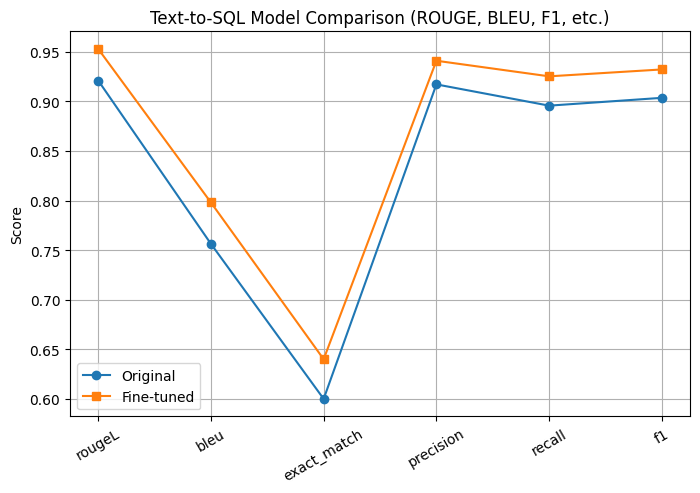

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
labels = list(m_orig.keys())
x = np.arange(len(labels))
orig_vals = [m_orig[k] for k in labels]
ft_vals = [m_ft[k] for k in labels]

plt.plot(x, orig_vals, marker='o', label='Original')
plt.plot(x, ft_vals, marker='s', label='Fine-tuned')
plt.xticks(x, labels, rotation=30)
plt.ylabel("Score")
plt.title("Text-to-SQL Model Comparison (ROUGE, BLEU, F1, etc.)")
plt.legend()
plt.grid(True)
plt.show()


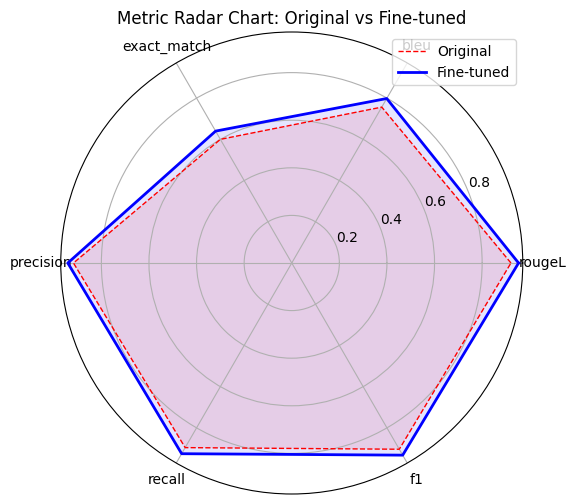

In [ ]:
from math import pi

labels = list(m_ft.keys())
orig = [m_orig[k] for k in labels]
ft = [m_ft[k] for k in labels]
angles = [n / float(len(labels)) * 2 * pi for n in range(len(labels))]
orig += orig[:1]; ft += ft[:1]; angles += angles[:1]

fig, ax = plt.subplots(subplot_kw=dict(polar=True), figsize=(6,6))
ax.plot(angles, orig, 'r--', linewidth=1, label='Original')
ax.fill(angles, orig, 'r', alpha=0.1)
ax.plot(angles, ft, 'b-', linewidth=2, label='Fine-tuned')
ax.fill(angles, ft, 'b', alpha=0.1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_title("Metric Radar Chart: Original vs Fine-tuned")
ax.legend(loc='upper right')
plt.show()


In [ ]:
out_df = pd.DataFrame([m_orig, m_ft], index=["Original", "Fine-tuned"])
out_df.to_csv("/kaggle/working/text2sql_eval_metrics.csv")
print("Saved metrics summary → /kaggle/working/text2sql_eval_metrics.csv")
out_df


In [ ]:
# ========================== CONFIG (bạn chỉ sửa phần này) ==========================
ORIG_DIR = "/kaggle/input/dt-olms-text2sql-ep1/sql_t5_finetuned"     # model gốc
FT_DIR   = "/kaggle/input/sql-t5-finetuned-v2/finetuned_model_2_epoch"                 # model ep2

MODE = "custom"           # "custom" | "random_synth" | "sample_from_merged"

# -- Dùng khi MODE="custom"
CUSTOM_SCHEMA = """\
CREATE TABLE coupons (CouponId INT, Code NVARCHAR, DiscountAmount DECIMAL, ExpiryDate DATETIME2, IsActive BIT, CreatedAt DATETIME2, DiscountPercent INT, MaxUsageCount INT, UsageCount INT);
CREATE TABLE courses (CourseId INT, Title NVARCHAR, Description NVARCHAR, IsPaid BIT, Price DECIMAL, CreatedAt DATETIME2, ImageUrl NVARCHAR, ExpiryDate DATETIME2, InstructorId INT);
CREATE TABLE enrollments (EnrollmentId INT, UserId INT, CourseId INT, IsCompleted BIT, CompletionDate DATETIME2, CreatedAt DATETIME2, ProgressPercent REAL);
CREATE TABLE instructors (UserId INT, Specialization NVARCHAR, Bio NVARCHAR);
CREATE TABLE lessonprogress (ProgressId INT, UserId INT, LessonId INT, IsCompleted BIT, CompletedAt DATETIME2, LastUpdate DATETIME2);
CREATE TABLE lessons (LessonId INT, CourseId INT, LessonType NVARCHAR, Title NVARCHAR, CreatedAt DATETIME2, Duration INT);
CREATE TABLE payments (PaymentId INT, UserId INT, CourseId INT, Amount DECIMAL, TransactionId NVARCHAR, ResponseMessage NVARCHAR, CreatedAt DATETIME2, CouponId INT, Method NVARCHAR, OrderInfo NVARCHAR, Status NVARCHAR, OrderId NVARCHAR);
CREATE TABLE quizresults (ResultId INT, UserId INT, LessonId INT, Score INT, SubmittedAt DATETIME2, CorrectAnswers INT, TotalQuestions INT);
CREATE TABLE quizzes (QuizId INT, LessonId INT, Question NVARCHAR, OptionA NVARCHAR, OptionB NVARCHAR, OptionC NVARCHAR, OptionD NVARCHAR, CorrectAnswer INT, ImageUrl NVARCHAR);
CREATE TABLE textlessons (TextId INT, LessonId INT, Content NVARCHAR);
CREATE TABLE users (UserId INT, Name NVARCHAR, Email NVARCHAR, PasswordHash NVARCHAR, Role NVARCHAR, IsActive BIT, CreatedAt DATETIME2, RefreshToken NVARCHAR, RefreshTokenExpiry DATETIME2, AvatarUrl NVARCHAR);
CREATE TABLE videolessons (VideoId INT, LessonId INT, YoutubeUrl NVARCHAR);
CREATE TABLE communitymessages (MessageId INT, SenderId INT, Content NVARCHAR, Attachment NVARCHAR, CreatedAt DATETIME2);
CREATE TABLE conversationmembers (Id INT, ConversationId UNIQUEIDENTIFIER, UserId INT, Role NVARCHAR, JoinedAt DATETIME2, LastReadAt DATETIME2);
CREATE TABLE conversations (Id UNIQUEIDENTIFIER, Type NVARCHAR, Title NVARCHAR, CreatedByUserId INT, CreatedAt DATETIME2);
CREATE TABLE messageattachments (Id UNIQUEIDENTIFIER, MessageId UNIQUEIDENTIFIER, Url NVARCHAR, FileName NVARCHAR, FileSize BIGINT, ContentType NVARCHAR, Width INT, Height INT);
CREATE TABLE messages (Id UNIQUEIDENTIFIER, ConversationId UNIQUEIDENTIFIER, SenderId INT, Content NVARCHAR, MessageType NVARCHAR, ReplyToMessageId UNIQUEIDENTIFIER, CreatedAt DATETIME2, EditedAt DATETIME2, DeletedAt DATETIME2);

"""
CUSTOM_QUESTION = "What are all info of users who have role student"
CUSTOM_EXPECTED = None     # có thể để None; nếu có, sẽ so exact_match

# -- Dùng khi MODE="sample_from_merged"
MERGED_DIR = "/kaggle/input/dt-olms-text2sql-ep1/merged_dataset"     # đã save_to_disk
SPLIT = "test"             # "test" | "validation" | "train"
INDEX = None               # nếu None → lấy ngẫu nhiên 1 mẫu trong split

# ============================= IMPLEMENTATION (không sửa) ==========================
import os, random, torch, pandas as pd, numpy as np
from datasets import load_from_disk
from transformers import T5ForConditionalGeneration, T5Tokenizer, GenerationConfig

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
orig_model = T5ForConditionalGeneration.from_pretrained(ORIG_DIR).to(DEVICE).eval()
ft_model   = T5ForConditionalGeneration.from_pretrained(FT_DIR).to(DEVICE).eval()
tok        = T5Tokenizer.from_pretrained(FT_DIR)
gen_cfg    = GenerationConfig(max_new_tokens=300, do_sample=False)

def build_prompt(question:str, schema:str|None):
    if schema and schema.strip():
        return f"Tables:\n{schema.strip()}\n\nQuestion:\n{question.strip()}\n\nAnswer:\n"
    return f"translate to sql: {question.strip()}"

def synthesize_schema_and_question():
    # ----- schema pool (OLMS-style + generic) -----
    TABLES = {
        "users":        ["id INT","name VARCHAR","email VARCHAR","role VARCHAR","created_at TIMESTAMP"],
        "courses":      ["id INT","title VARCHAR","price DECIMAL","instructor_id INT","created_at TIMESTAMP"],
        "instructors":  ["id INT","name VARCHAR","rating DECIMAL","joined_at DATE"],
        "enrollments":  ["id INT","user_id INT","course_id INT","purchased_at TIMESTAMP"],
        "orders":       ["id INT","user_id INT","amount DECIMAL","paid_at TIMESTAMP","status VARCHAR"],
        "coupons":      ["id INT","code VARCHAR","discount INT","expires_at DATE"],
        "progress":     ["id INT","user_id INT","course_id INT","lesson INT","done_at TIMESTAMP"]
    }
    k = random.randint(3,4)
    chosen = random.sample(list(TABLES.keys()), k)
    lines = []
    for t in chosen:
        cols = ", ".join(random.sample(TABLES[t], min(3, len(TABLES[t]))))
        lines.append(f"{t}({cols})")
    schema = "\n".join(lines)

    # ---- question templates (English, natural keywords the model learned) ----
    qs = [
        "show all courses with price greater than 50 ordered by price desc limit 5",
        "count users who enrolled in any course in the last 7 days",
        "list top 3 instructors by rating",
        "find total revenue by day in 2024",
        "show user name and course title for the most recent 5 enrollments",
        "list courses with active coupons",
        "how many orders are paid today",
    ]
    return schema, random.choice(qs)

def load_one_from_merged(dir_path, split, index=None):
    ds = load_from_disk(dir_path)
    data = ds[split] if split in ds else ds["validation"]
    cols = set(data.column_names)
    def pick(cands): 
        for c in cands:
            if c in cols: return c
        return None
    q_col = pick(["question","nl_question","input","utterance","Query","instruction"])
    a_col = pick(["answer","sql","sql_query","query","response"])
    c_col = pick(["context","schema","tables","db_schema","text"])

    i = index if (index is not None and 0 <= index < len(data)) else random.randrange(len(data))
    row = data.select([i])[0]
    question = str(row[q_col])
    answer   = str(row[a_col])
    context  = str(row[c_col]) if c_col and row.get(c_col) is not None else ""
    return question, answer, context

# -------- build test case (question, context, expected) ----------
if MODE == "custom":
    question = CUSTOM_QUESTION
    context  = CUSTOM_SCHEMA
    expected = CUSTOM_EXPECTED
elif MODE == "random_synth":
    context, question = synthesize_schema_and_question()
    expected = None
elif MODE == "sample_from_merged":
    question, expected, context = load_one_from_merged(MERGED_DIR, SPLIT, INDEX)
else:
    raise ValueError("MODE must be one of: custom | random_synth | sample_from_merged")

prompt = build_prompt(question, context)

# ------------- generate with both models ----------------
def generate_sql(model, prompt):
    ids = tok(prompt, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        out = model.generate(**ids, generation_config=gen_cfg)
    txt = tok.decode(out[0], skip_special_tokens=True).strip()
    return txt if txt.endswith(";") else txt + ";"

orig_sql = generate_sql(orig_model, prompt)
ft_sql   = generate_sql(ft_model,   prompt)

# ------------- report ----------------
def exact(a,b):
    if a is None: return None
    return int(str(a).strip().lower() == str(b).strip().lower())

row = {
    "mode": MODE,
    "question (input)": question,
    "context/schema": context,
    "expected (optional)": expected,
    "original_sql": orig_sql,
    "finetuned_sql": ft_sql,
    "exact_match_ft": exact(expected, ft_sql),
    "exact_match_orig": exact(expected, orig_sql),
    "prompt_used": prompt
}
pd.set_option("display.max_colwidth", None)
display(pd.DataFrame([row])[["mode","question (input)","context/schema","expected (optional)","original_sql","finetuned_sql","exact_match_orig","exact_match_ft"]])

print("\n--- Prompt sent to model (exactly like training template) ---\n")
print(prompt)


Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 512). Running this sequence through the model will result in indexing errors


,mode,question (input),context/schema,expected (optional),original_sql,finetuned_sql,exact_match_orig,exact_match_ft
0,custom,What are all info of users who have role student,"CREATE TABLE coupons (CouponId INT, Code NVARCHAR, DiscountAmount DECIMAL, ExpiryDate DATETIME2, IsActive BIT, CreatedAt DATETIME2, DiscountPercent INT, MaxUsageCount INT, UsageCount INT);\nCREATE TABLE courses (CourseId INT, Title NVARCHAR, Description NVARCHAR, IsPaid BIT, Price DECIMAL, CreatedAt DATETIME2, ImageUrl NVARCHAR, ExpiryDate DATETIME2, InstructorId INT);\nCREATE TABLE enrollments (EnrollmentId INT, UserId INT, CourseId INT, IsCompleted BIT, CompletionDate DATETIME2, CreatedAt DATETIME2, ProgressPercent REAL);\nCREATE TABLE instructors (UserId INT, Specialization NVARCHAR, Bio NVARCHAR);\nCREATE TABLE lessonprogress (ProgressId INT, UserId INT, LessonId INT, IsCompleted BIT, CompletedAt DATETIME2, LastUpdate DATETIME2);\nCREATE TABLE lessons (LessonId INT, CourseId INT, LessonType NVARCHAR, Title NVARCHAR, CreatedAt DATETIME2, Duration INT);\nCREATE TABLE payments (PaymentId INT, UserId INT, CourseId INT, Amount DECIMAL, TransactionId NVARCHAR, ResponseMessage NVARCHAR, CreatedAt DATETIME2, CouponId INT, Method NVARCHAR, OrderInfo NVARCHAR, Status NVARCHAR, OrderId NVARCHAR);\nCREATE TABLE quizresults (ResultId INT, UserId INT, LessonId INT, Score INT, SubmittedAt DATETIME2, CorrectAnswers INT, TotalQuestions INT);\nCREATE TABLE quizzes (QuizId INT, LessonId INT, Question NVARCHAR, OptionA NVARCHAR, OptionB NVARCHAR, OptionC NVARCHAR, OptionD NVARCHAR, CorrectAnswer INT, ImageUrl NVARCHAR);\nCREATE TABLE textlessons (TextId INT, LessonId INT, Content NVARCHAR);\nCREATE TABLE users (UserId INT, Name NVARCHAR, Email NVARCHAR, PasswordHash NVARCHAR, Role NVARCHAR, IsActive BIT, CreatedAt DATETIME2, RefreshToken NVARCHAR, RefreshTokenExpiry DATETIME2, AvatarUrl NVARCHAR);\nCREATE TABLE videolessons (VideoId INT, LessonId INT, YoutubeUrl NVARCHAR);\nCREATE TABLE communitymessages (MessageId INT, SenderId INT, Content NVARCHAR, Attachment NVARCHAR, CreatedAt DATETIME2);\nCREATE TABLE conversationmembers (Id INT, ConversationId UNIQUEIDENTIFIER, UserId INT, Role NVARCHAR, JoinedAt DATETIME2, LastReadAt DATETIME2);\nCREATE TABLE conversations (Id UNIQUEIDENTIFIER, Type NVARCHAR, Title NVARCHAR, CreatedByUserId INT, CreatedAt DATETIME2);\nCREATE TABLE messageattachments (Id UNIQUEIDENTIFIER, MessageId UNIQUEIDENTIFIER, Url NVARCHAR, FileName NVARCHAR, FileSize BIGINT, ContentType NVARCHAR, Width INT, Height INT);\nCREATE TABLE messages (Id UNIQUEIDENTIFIER, ConversationId UNIQUEIDENTIFIER, SenderId INT, Content NVARCHAR, MessageType NVARCHAR, ReplyToMessageId UNIQUEIDENTIFIER, CreatedAt DATETIME2, EditedAt DATETIME2, DeletedAt DATETIME2);\n\n",None,"SELECT T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.CreationDate, T1.CreationDate, T1.Score, T1.Score, T1.Score, T1.Score, T1.Name AS T1 JOIN Users AS T2 ON T1.UserId = T2.Id WHERE T1.Score >= '##UserId##' GROUP BY T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Name, T1.Score, T1.Score, T1.Score, T1.Score, T1.Score, T1.;",SELECT * FROM users WHERE Reputation >= '##Minitive?';,None,None



--- Prompt sent to model (exactly like training template) ---

Tables:
CREATE TABLE coupons (CouponId INT, Code NVARCHAR, DiscountAmount DECIMAL, ExpiryDate DATETIME2, IsActive BIT, CreatedAt DATETIME2, DiscountPercent INT, MaxUsageCount INT, UsageCount INT);
CREATE TABLE courses (CourseId INT, Title NVARCHAR, Description NVARCHAR, IsPaid BIT, Price DECIMAL, CreatedAt DATETIME2, ImageUrl NVARCHAR, ExpiryDate DATETIME2, InstructorId INT);
CREATE TABLE enrollments (EnrollmentId INT, UserId INT, CourseId INT, IsCompleted BIT, CompletionDate DATETIME2, CreatedAt DATETIME2, ProgressPercent REAL);
CREATE TABLE instructors (UserId INT, Specialization NVARCHAR, Bio NVARCHAR);
CREATE TABLE lessonprogress (ProgressId INT, UserId INT, LessonId INT, IsCompleted BIT, CompletedAt DATETIME2, LastUpdate DATETIME2);
CREATE TABLE lessons (LessonId INT, CourseId INT, LessonType NVARCHAR, Title NVARCHAR, CreatedAt DATETIME2, Duration INT);
CREATE TABLE payments (PaymentId INT, UserId INT, CourseId INT, A